In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import matplotlib.pyplot as plt

from data.dataLoader import ClientPreprocessTrain, ClientPreprocessTest, GlobalPreprocess
from data.distribution import data_label_distribution
from globle.trainer.trainer import GlobalTrainer
from globle.trainer.evaluator import GlobalEvaluator
from client.trainer.trainer import ClientTrainer
from client.trainer.evaluator import ClientEvaluator
from models.models import model
from configs.confLoader import *

Files already downloaded and verified
digits	count
Airplane:	2
Automobile:	1
Bird:	1
Cat:	3
Deer:	1
Dog:	3
Horse:	1
Ship:	2
Truck:	2
torch.Size([16, 3, 32, 32])


C:\Users\MAADUR~1\AppData\Local\Temp/ipykernel_6452/174204973.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  plt.imshow(data[i].T)


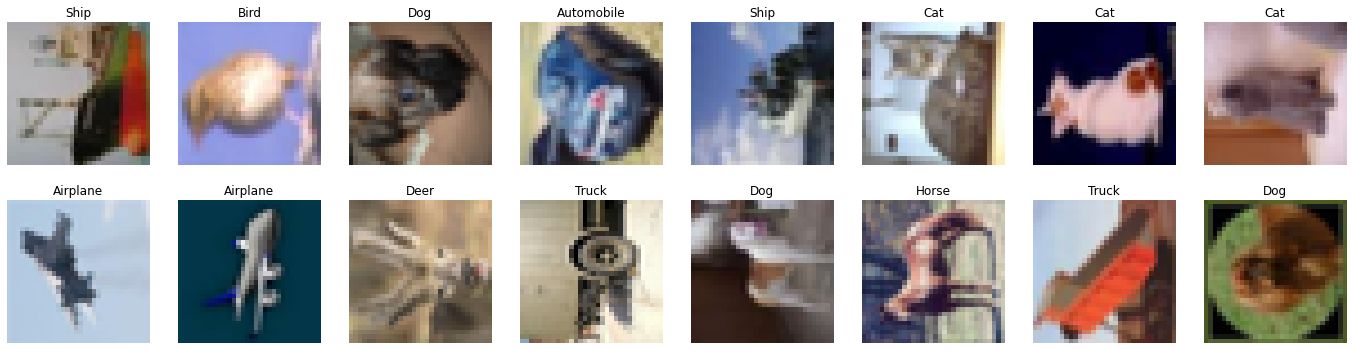

In [2]:
label_dict = {0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat',
              4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}

client_test = ClientPreprocessTest()
data, target = next(iter(client_test[0]))
label_count = (torch.unique(target, return_counts=True))
print('digits\tcount')
for label, count in zip(label_count[0], label_count[1]):
    print(label_dict[int(label)], ':\t', int(count), sep='')
print(data.shape)
fig = plt.figure(figsize=(24, 6))
for i in range(len(target)):
    fig.add_subplot(2, 8, (i+1))
    plt.imshow(data[i].T)
    plt.axis('off')
    plt.title(label_dict[int(target[i])])


In [3]:
global_model = model
print(global_model)

CNN(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=2048, out_features=1024, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [4]:
global_trainer = GlobalTrainer(global_model)

Files already downloaded and verified


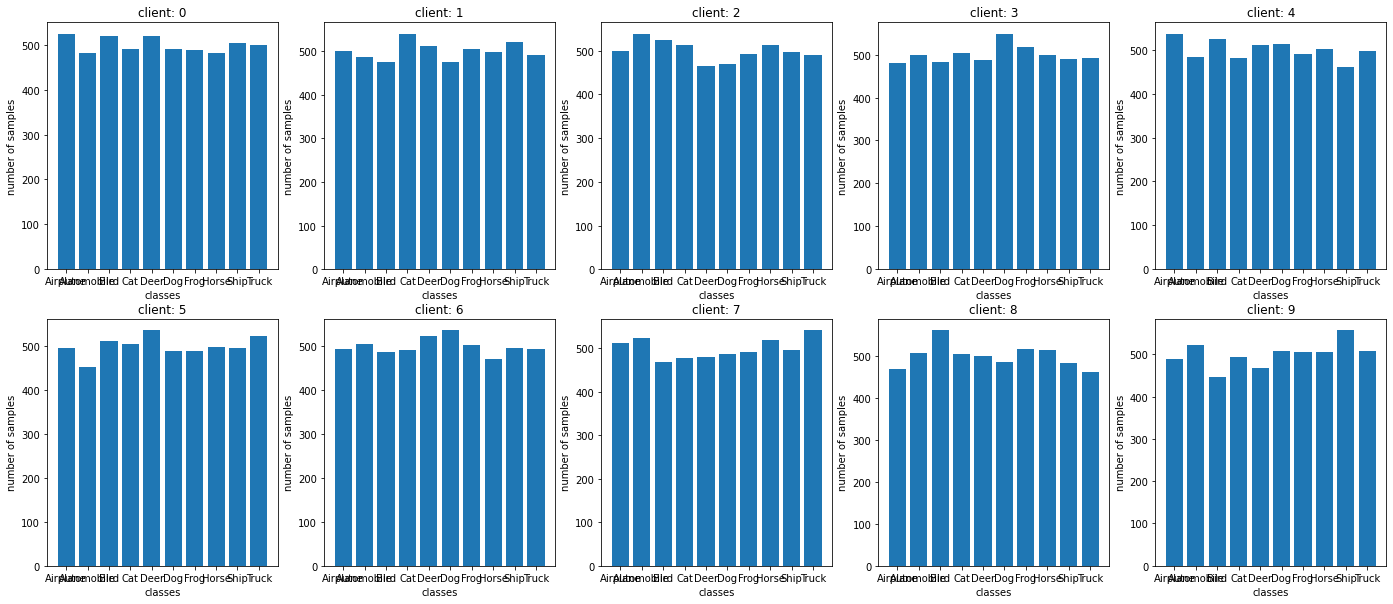

In [5]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    distribution = data_label_distribution(global_trainer.trainset[i])
    plt.bar([label_dict[i] for i in distribution.keys()], distribution.values())
    plt.title(f'client: {i}')
    plt.xlabel('classes')
    plt.ylabel('number of samples')


In [6]:
global_trainer.train()

client [1]: 100%|██████████| 10/10 [00:01<00:00,  6.93it/s]


3
[tensor([ 0.0251, -0.0979,  0.0350,  ...,  0.2332,  0.0379,  0.0896]), tensor([ 0.0779, -0.0479,  0.0835,  ...,  0.0809,  0.1394, -0.0745]), tensor([ 0.1019, -0.0236,  0.1055,  ...,  0.0898, -0.0598,  0.2020])]


global_training_epoch:   0%|          | 1/200 [00:04<13:31,  4.08s/it]

tensor([ 0.0683, -0.0565,  0.0746,  ...,  0.1347,  0.0392,  0.0723])


global_training_epoch:   1%|          | 2/200 [00:08<13:43,  4.16s/it]

3
[tensor([-0.1134, -0.1155, -0.1146,  ..., -0.2250, -0.0748,  0.3607]), tensor([-0.0892, -0.0916, -0.0912,  ..., -0.2067,  0.0869,  0.3343]), tensor([ 0.0037,  0.0028,  0.0054,  ..., -0.0478, -0.0915, -0.1883])]
tensor([-0.0049, -0.1189,  0.0004,  ..., -0.0386,  0.0088,  0.2340])


global_training_epoch:   2%|▏         | 3/200 [00:11<12:10,  3.71s/it]

3
[tensor([-0.0361,  0.0769, -0.0425,  ..., -0.2664,  0.0926, -0.3286]), tensor([-0.0365,  0.0767, -0.0428,  ..., -0.2264, -0.0617,  0.0880]), tensor([-0.0986,  0.0146, -0.1049,  ..., -0.1677,  0.4240,  0.1361])]
tensor([-0.0614, -0.0510, -0.0630,  ..., -0.2549,  0.1595,  0.1758])


global_training_epoch:   2%|▏         | 4/200 [00:14<11:53,  3.64s/it]

3
[tensor([-0.0883,  0.0151, -0.0918,  ...,  0.0997, -0.0216, -0.3633]), tensor([-0.0881,  0.0147, -0.0930,  ...,  0.0665, -0.0940, -0.0994]), tensor([-0.0754,  0.0272, -0.0798,  ...,  0.5133,  0.2611, -0.0239])]
tensor([-0.1392, -0.0269, -0.1450,  ..., -0.0030,  0.1921, -0.0040])


global_training_epoch:   2%|▎         | 5/200 [00:17<11:01,  3.39s/it]

3
[tensor([ 0.0374,  0.0278,  0.0386,  ...,  0.5815,  0.0728, -0.0722]), tensor([ 0.0459,  0.0364,  0.0473,  ...,  0.1571,  0.0628, -0.0465]), tensor([ 0.0515,  0.0419,  0.0528,  ...,  0.2892, -0.4129, -0.0781])]
tensor([-0.0804,  0.0111, -0.0842,  ...,  0.3399,  0.0804, -0.0692])


global_training_epoch:   3%|▎         | 6/200 [00:20<10:30,  3.25s/it]

3
[tensor([ 0.0658, -0.0355,  0.0709,  ..., -0.2801, -0.3142, -0.0256]), tensor([ 0.0629, -0.0381,  0.0680,  ..., -0.0925, -0.2397, -0.2403]), tensor([ 0.1029,  0.0018,  0.1077,  ...,  0.1915, -0.0661,  0.0056])]
tensor([ 0.0049, -0.0139,  0.0064,  ...,  0.2456, -0.1343, -0.1490])


global_training_epoch:   4%|▎         | 7/200 [00:24<10:56,  3.40s/it]

3
[tensor([ 0.1359,  0.0531,  0.1396,  ..., -0.3658, -0.1686,  0.0044]), tensor([ 0.1415,  0.0589,  0.1448,  ..., -0.0291,  0.1277,  0.0316]), tensor([0.1373, 0.0546, 0.1406,  ..., 0.0329, 0.1497, 0.1804])]
tensor([ 0.1426,  0.0430,  0.1474,  ...,  0.1003, -0.0846, -0.0620])


global_training_epoch:   4%|▍         | 8/200 [00:27<10:15,  3.21s/it]

3
[tensor([ 0.0344,  0.0515,  0.0334,  ..., -0.5328, -0.0123,  0.2060]), tensor([ 0.0930,  0.1097,  0.0916,  ..., -0.1183,  0.0884, -0.1113]), tensor([ 0.0883,  0.1055,  0.0880,  ..., -0.1274,  0.1447,  0.2401])]
tensor([ 0.2003,  0.1277,  0.2037,  ..., -0.1692, -0.0025,  0.0558])


global_training_epoch:   4%|▍         | 9/200 [00:30<10:12,  3.21s/it]

3
[tensor([-0.1223, -0.0325, -0.1270,  ..., -0.5485, -0.2672,  0.1749]), tensor([-0.1043, -0.0145, -0.1089,  ..., -0.5818,  0.0729, -0.1861]), tensor([-0.1372, -0.0475, -0.1420,  ..., -0.5636, -0.2553, -0.2453])]
tensor([ 0.0590,  0.0834,  0.0573,  ..., -0.7169, -0.1521, -0.0353])


client [8]: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


3
[tensor([-0.1029, -0.0376, -0.1059,  ...,  0.2786, -0.1491, -0.0366]), tensor([-0.1460, -0.0806, -0.1492,  ...,  0.2761,  0.3278,  0.1500]), tensor([-0.0877, -0.0224, -0.0908,  ...,  0.1404, -0.2755, -0.0687])]
tensor([-0.0591,  0.0282, -0.0637,  ..., -0.4135, -0.1692, -0.0168])


client [6]: 100%|██████████| 10/10 [00:01<00:00,  9.36it/s]


3
[tensor([ 0.0056, -0.0164,  0.0071,  ...,  0.5969,  0.0673, -0.0445]), tensor([-0.0736, -0.0956, -0.0721,  ...,  0.6595,  0.5027,  0.2603]), tensor([-0.0117, -0.0336, -0.0102,  ...,  0.5083,  0.4187, -0.0609])]
tensor([-0.0798, -0.0232, -0.0824,  ...,  0.2161,  0.1773,  0.0365])


global_training_epoch:   6%|▌         | 12/200 [00:40<10:15,  3.27s/it]

3
[tensor([ 0.1046,  0.0260,  0.1087,  ...,  0.5063, -0.0208, -0.0299]), tensor([ 0.0733, -0.0052,  0.0774,  ...,  0.4714, -0.0107,  0.1561]), tensor([ 0.0588, -0.0200,  0.0628,  ...,  0.9539, -0.1934, -0.1130])]
tensor([ 0.0071, -0.0206,  0.0089,  ...,  0.8383,  0.0846,  0.0373])


client [8]: 100%|██████████| 10/10 [00:00<00:00, 12.06it/s]


3
[tensor([ 0.0929,  0.0420,  0.0952,  ..., -0.3255,  0.0639, -0.1006]), tensor([ 0.0523,  0.0015,  0.0550,  ..., -0.4688, -0.2043, -0.2238]), tensor([ 0.0974,  0.0466,  0.1002,  ..., -0.3351, -0.2832, -0.1998])]


global_training_epoch:   6%|▋         | 13/200 [00:43<09:54,  3.18s/it]

tensor([ 0.0873,  0.0115,  0.0914,  ...,  0.3780, -0.0651, -0.1412])


global_training_epoch:   7%|▋         | 14/200 [00:46<09:06,  2.94s/it]

3
[tensor([-0.0861, -0.0612, -0.0879,  ..., -0.4409, -0.0557,  0.0908]), tensor([-0.0747, -0.0500, -0.0765,  ..., -0.5159,  0.0592,  0.0370]), tensor([-0.0008,  0.0240, -0.0027,  ..., -0.3301, -0.0629,  0.0527])]
tensor([ 0.0246, -0.0187,  0.0266,  ..., -0.0888, -0.0784, -0.0669])


global_training_epoch:   8%|▊         | 15/200 [00:48<08:31,  2.77s/it]

3
[tensor([-0.0115,  0.0568, -0.0152,  ..., -0.4927,  0.2371,  0.1369]), tensor([-0.0234,  0.0449, -0.0271,  ..., -0.8375,  0.3523,  0.2589]), tensor([-0.0658,  0.0025, -0.0691,  ..., -0.1643,  0.0447,  0.3689])]
tensor([-0.0114,  0.0179, -0.0132,  ..., -0.5781,  0.1408,  0.1947])


global_training_epoch:   8%|▊         | 16/200 [00:51<08:19,  2.71s/it]

3
[tensor([-0.0336,  0.0055, -0.0355,  ..., -0.0679, -0.1224, -0.1453]), tensor([-0.0277,  0.0113, -0.0296,  ...,  0.1706,  0.0457, -0.0320]), tensor([0.0045, 0.0435, 0.0026,  ..., 0.0225, 0.1551, 0.0068])]
tensor([-0.0292,  0.0362, -0.0327,  ..., -0.4785,  0.1529,  0.1184])


global_training_epoch:   8%|▊         | 17/200 [00:53<08:09,  2.68s/it]

3
[tensor([ 0.0246, -0.0018,  0.0262,  ...,  0.4838, -0.1108, -0.1245]), tensor([-0.0167, -0.0429, -0.0150,  ...,  0.2688, -0.0466, -0.2131]), tensor([ 0.0217, -0.0046,  0.0233,  ...,  0.1975, -0.1523, -0.1945])]
tensor([-0.0164,  0.0161, -0.0179,  ..., -0.1139,  0.0344, -0.0708])


global_training_epoch:   9%|▉         | 18/200 [00:55<07:47,  2.57s/it]

3
[tensor([ 0.0497, -0.0091,  0.0529,  ...,  0.6919, -0.1190,  0.0490]), tensor([ 0.0488, -0.0100,  0.0522,  ...,  0.4348, -0.4923, -0.1071]), tensor([ 0.0503, -0.0085,  0.0535,  ...,  0.6673, -0.2896, -0.0597])]
tensor([ 0.0348,  0.0053,  0.0367,  ...,  0.4955, -0.2693, -0.1029])


global_training_epoch:  10%|▉         | 19/200 [00:58<07:32,  2.50s/it]

3
[tensor([-0.0009, -0.0301,  0.0004,  ...,  0.1371,  0.2020, -0.1266]), tensor([ 0.0187, -0.0105,  0.0200,  ...,  0.2261,  0.0593, -0.0458]), tensor([ 0.0181, -0.0111,  0.0194,  ...,  0.2365,  0.1774, -0.0499])]
tensor([ 0.0433, -0.0125,  0.0463,  ...,  0.6458, -0.0962, -0.1668])


global_training_epoch:  10%|█         | 20/200 [01:00<07:28,  2.49s/it]

3
[tensor([-0.0299, -0.0033, -0.0316,  ..., -0.7618,  0.1945,  0.2148]), tensor([-0.0494, -0.0227, -0.0508,  ..., -0.1138,  0.2143,  0.4335]), tensor([-0.0244,  0.0022, -0.0261,  ..., -0.3777,  0.2063,  0.1534])]
tensor([ 0.0045, -0.0192,  0.0055,  ...,  0.1635,  0.1185,  0.1171])


global_training_epoch:  10%|█         | 21/200 [01:03<07:16,  2.44s/it]

3
[tensor([-0.0384,  0.0118, -0.0411,  ..., -0.2448,  0.1485,  0.3075]), tensor([-0.0306,  0.0197, -0.0333,  ..., -0.7193,  0.0964,  0.1274]), tensor([-0.0359,  0.0144, -0.0387,  ..., -0.6112,  0.2166, -0.0473])]
tensor([-0.0309, -0.0020, -0.0327,  ..., -0.3780,  0.2604,  0.2346])


global_training_epoch:  11%|█         | 22/200 [01:05<07:26,  2.51s/it]

3
[tensor([ 0.0013,  0.0226,  0.0003,  ..., -0.2926, -0.0532, -0.2967]), tensor([-0.0012,  0.0201, -0.0022,  ...,  0.1497, -0.1124,  0.0607]), tensor([ 0.0025,  0.0238,  0.0015,  ..., -0.1518, -0.1116, -0.5646])]
tensor([-0.0270,  0.0204, -0.0296,  ..., -0.4384,  0.1420, -0.0557])


global_training_epoch:  12%|█▏        | 23/200 [01:08<07:12,  2.44s/it]

3
[tensor([ 0.0282,  0.0021,  0.0298,  ..., -0.0972, -0.4938, -0.2180]), tensor([ 0.0292,  0.0031,  0.0308,  ...,  0.2687, -0.2707, -0.1195]), tensor([ 0.0209, -0.0052,  0.0224,  ...,  0.5307, -0.3452, -0.0912])]
tensor([ 0.0018,  0.0183,  0.0010,  ..., -0.1605, -0.2421, -0.1931])


global_training_epoch:  12%|█▏        | 24/200 [01:10<07:22,  2.52s/it]

3
[tensor([ 0.0253, -0.0174,  0.0276,  ...,  0.2240, -0.1183,  0.0247]), tensor([ 0.0277, -0.0149,  0.0300,  ...,  0.2048, -0.2524, -0.0165]), tensor([ 0.0281, -0.0145,  0.0304,  ...,  0.0088, -0.0581, -0.0388])]
tensor([ 0.0286,  0.0009,  0.0303,  ...,  0.0014, -0.3609, -0.1839])


global_training_epoch:  12%|█▎        | 25/200 [01:13<07:33,  2.59s/it]

3
[tensor([-0.0019, -0.0168, -0.0012,  ...,  0.7475,  0.3659,  0.3528]), tensor([-0.0014, -0.0163, -0.0008,  ...,  0.3610,  0.1047,  0.1859]), tensor([-6.0911e-04, -1.5490e-02,  4.6199e-05,  ...,  3.2887e-01,
         3.3222e-01,  2.0171e-02])]
tensor([ 0.0244, -0.0154,  0.0266,  ...,  0.4804, -0.0572,  0.0207])


global_training_epoch:  13%|█▎        | 26/200 [01:15<07:26,  2.57s/it]

3
[tensor([-0.0282, -0.0033, -0.0297,  ...,  0.2420,  0.3596,  0.2529]), tensor([-0.0339, -0.0089, -0.0354,  ..., -0.2385,  0.5776,  0.3900]), tensor([-2.5121e-02, -1.6448e-04, -2.6624e-02,  ..., -8.1184e-02,
         3.0370e-01, -4.0625e-02])]
tensor([-0.0071, -0.0180, -0.0066,  ...,  0.4065,  0.3622,  0.2194])


global_training_epoch:  14%|█▎        | 27/200 [01:18<07:29,  2.60s/it]

3
[tensor([-0.0394, -0.0035, -0.0411,  ..., -0.6847, -0.3257, -0.1791]), tensor([-0.0190,  0.0168, -0.0210,  ..., -0.1973,  0.0079,  0.0270]), tensor([-0.0183,  0.0175, -0.0203,  ..., -0.1579,  0.0542, -0.2544])]
tensor([-0.0320, -0.0059, -0.0335,  ...,  0.0192,  0.2381,  0.0620])


global_training_epoch:  14%|█▍        | 28/200 [01:21<07:26,  2.60s/it]

3
[tensor([ 0.0140,  0.0238,  0.0136,  ..., -0.1915, -0.1719, -0.0741]), tensor([ 0.0143,  0.0241,  0.0138,  ..., -0.6758, -0.2240, -0.0699]), tensor([ 0.0138,  0.0236,  0.0134,  ..., -0.6559, -0.3734, -0.2005])]
tensor([-0.0147,  0.0185, -0.0165,  ..., -0.4905, -0.0422, -0.0591])


global_training_epoch:  14%|█▍        | 29/200 [01:23<07:08,  2.50s/it]

3
[tensor([ 0.0279,  0.0045,  0.0293,  ..., -0.0610, -0.1955,  0.1024]), tensor([ 0.0291,  0.0056,  0.0304,  ..., -0.0613, -0.1599,  0.0579]), tensor([ 0.0256,  0.0022,  0.0269,  ..., -0.0917, -0.0216,  0.1867])]
tensor([ 0.0143,  0.0207,  0.0140,  ..., -0.5127, -0.1636,  0.0625])


global_training_epoch:  15%|█▌        | 30/200 [01:26<07:21,  2.59s/it]

3
[tensor([ 0.0147, -0.0152,  0.0163,  ...,  0.5237, -0.2995, -0.2160]), tensor([ 0.0150, -0.0149,  0.0167,  ...,  0.3360, -0.2997, -0.2543]), tensor([ 0.0135, -0.0164,  0.0151,  ...,  0.4757, -0.1649, -0.2927])]
tensor([ 0.0273,  0.0032,  0.0286,  ..., -0.0163, -0.4020, -0.1981])


global_training_epoch:  16%|█▌        | 31/200 [01:29<07:33,  2.69s/it]

3
[tensor([-0.0129, -0.0188, -0.0127,  ...,  0.5164,  0.2007,  0.0674]), tensor([-0.0126, -0.0184, -0.0123,  ...,  0.5243,  0.4005,  0.0424]), tensor([-0.0123, -0.0181, -0.0120,  ...,  0.3258,  0.1795, -0.0326])]
tensor([ 0.0119, -0.0156,  0.0134,  ...,  0.4408, -0.1016, -0.1526])


global_training_epoch:  16%|█▌        | 32/200 [01:31<07:27,  2.66s/it]

3
[tensor([-0.0248, -0.0031, -0.0260,  ...,  0.0729,  0.4951,  0.3471]), tensor([-0.0245, -0.0028, -0.0257,  ...,  0.3484,  0.5978,  0.3427]), tensor([-0.0242, -0.0025, -0.0254,  ..., -0.0157,  0.3655,  0.1683])]
tensor([-0.0138, -0.0168, -0.0137,  ...,  0.5319,  0.3947,  0.1488])


global_training_epoch:  16%|█▋        | 33/200 [01:34<07:12,  2.59s/it]

3
[tensor([-0.0108,  0.0140, -0.0121,  ..., -0.4298,  0.1253,  0.2449]), tensor([-0.0193,  0.0054, -0.0206,  ..., -0.6444, -0.1176,  0.0450]), tensor([-0.0109,  0.0139, -0.0122,  ..., -0.5354, -0.2154,  0.1236])]
tensor([-0.0261, -0.0041, -0.0273,  ..., -0.0578,  0.2860,  0.2717])


global_training_epoch:  17%|█▋        | 34/200 [01:37<07:25,  2.69s/it]

3
[tensor([ 0.0154,  0.0182,  0.0153,  ..., -0.1590, -0.1428, -0.1099]), tensor([ 0.0154,  0.0182,  0.0153,  ..., -0.3853, -0.1640, -0.0552]), tensor([ 0.0121,  0.0148,  0.0120,  ..., -0.5488, -0.3339, -0.1768])]
tensor([-0.0092,  0.0134, -0.0104,  ..., -0.4164,  0.0439,  0.1305])


global_training_epoch:  18%|█▊        | 35/200 [01:40<07:44,  2.82s/it]

3
[tensor([ 0.0245,  0.0047,  0.0256,  ...,  0.0232, -0.2088, -0.2782]), tensor([ 0.0240,  0.0042,  0.0251,  ...,  0.2771, -0.2004, -0.2151]), tensor([ 0.0246,  0.0048,  0.0257,  ...,  0.2791, -0.1562, -0.1558])]
tensor([ 0.0161,  0.0166,  0.0161,  ..., -0.1816, -0.1490, -0.0989])


global_training_epoch:  18%|█▊        | 36/200 [01:44<08:27,  3.10s/it]

3
[tensor([ 0.0082, -0.0121,  0.0093,  ...,  0.4449, -0.0315, -0.3336]), tensor([ 0.0084, -0.0119,  0.0094,  ...,  0.1763, -0.2144, -0.1335]), tensor([ 0.0084, -0.0119,  0.0095,  ...,  0.2152, -0.1888, -0.2216])]
tensor([ 0.0229,  0.0030,  0.0239,  ...,  0.1154, -0.2789, -0.3185])


global_training_epoch:  18%|█▊        | 37/200 [01:46<07:56,  2.92s/it]

3
[tensor([-0.0144, -0.0149, -0.0144,  ...,  0.1461,  0.2451,  0.2207]), tensor([-0.0144, -0.0149, -0.0144,  ...,  0.4221,  0.2898,  0.2252]), tensor([-0.0145, -0.0149, -0.0145,  ...,  0.3225,  0.2641, -0.0525])]
tensor([ 0.0061, -0.0122,  0.0071,  ...,  0.4007,  0.0153, -0.1556])


global_training_epoch:  19%|█▉        | 38/200 [01:48<07:18,  2.71s/it]

3
[tensor([-0.0205, -0.0027, -0.0215,  ...,  0.0452,  0.2926,  0.3821]), tensor([-0.0206, -0.0027, -0.0215,  ..., -0.2479, -0.2153,  0.2485]), tensor([-0.0204, -0.0026, -0.0214,  ..., -0.3486,  0.0625,  0.2370])]
tensor([-0.0150, -0.0136, -0.0151,  ...,  0.1769,  0.0603,  0.1492])


global_training_epoch:  20%|█▉        | 39/200 [01:50<06:49,  2.54s/it]

3
[tensor([-0.0069,  0.0096, -0.0077,  ..., -0.5513,  0.0174,  0.0459]), tensor([-0.0056,  0.0109, -0.0064,  ..., -0.1881,  0.2634,  0.2408]), tensor([-0.0056,  0.0109, -0.0064,  ..., -0.4373,  0.2150,  0.2603])]
tensor([-0.0195, -0.0018, -0.0204,  ..., -0.2330,  0.2196,  0.3166])


global_training_epoch:  20%|██        | 40/200 [01:53<07:01,  2.64s/it]

3
[tensor([ 0.0139,  0.0127,  0.0140,  ..., -0.0116, -0.0856, -0.1822]), tensor([ 0.0139,  0.0127,  0.0140,  ...,  0.0282,  0.0418, -0.0857]), tensor([ 0.0139,  0.0127,  0.0140,  ..., -0.2163,  0.0145, -0.0659])]
tensor([-0.0036,  0.0111, -0.0044,  ..., -0.2763,  0.1878,  0.1737])


global_training_epoch:  20%|██        | 41/200 [01:56<06:51,  2.59s/it]

3
[tensor([ 0.0176,  0.0016,  0.0184,  ...,  0.0691, -0.1926, -0.2659]), tensor([ 0.0176,  0.0016,  0.0184,  ...,  0.3353, -0.1289, -0.2864]), tensor([ 0.0175,  0.0016,  0.0184,  ...,  0.0192, -0.3814, -0.2329])]
tensor([ 0.0143,  0.0116,  0.0144,  ..., -0.1075, -0.0653, -0.1054])


global_training_epoch:  21%|██        | 42/200 [01:58<06:37,  2.51s/it]

3
[tensor([ 0.0033, -0.0100,  0.0040,  ...,  0.1170, -0.3375, -0.2663]), tensor([ 0.0033, -0.0100,  0.0039,  ...,  0.1591, -0.3141, -0.2566]), tensor([ 0.0028, -0.0105,  0.0035,  ...,  0.0991, -0.2976, -0.5174])]
tensor([ 1.5959e-02,  2.7107e-04,  1.6800e-02,  ...,  2.8350e-02,
        -3.7510e-01, -4.4158e-01])


global_training_epoch:  22%|██▏       | 43/200 [02:01<06:52,  2.63s/it]

3
[tensor([-0.0129, -0.0104, -0.0130,  ...,  0.1363,  0.0762, -0.0731]), tensor([-0.0129, -0.0104, -0.0130,  ...,  0.1313,  0.0869,  0.2642]), tensor([-0.0127, -0.0103, -0.0129,  ...,  0.1286,  0.1346,  0.2035])]
tensor([ 0.0015, -0.0101,  0.0022,  ...,  0.1576, -0.2384, -0.2659])


global_training_epoch:  22%|██▏       | 44/200 [02:03<06:29,  2.50s/it]

3
[tensor([-1.4247e-02, -1.2840e-04, -1.5005e-02,  ..., -4.7326e-02,
         2.8543e-01,  4.6745e-01]), tensor([-1.4235e-02, -1.1619e-04, -1.4993e-02,  ...,  1.2048e-01,
         4.1384e-01,  4.7502e-01]), tensor([-1.4300e-02, -1.8137e-04, -1.5058e-02,  ..., -3.0866e-02,
         3.2885e-01,  4.4790e-01])]
tensor([-0.0129, -0.0093, -0.0131,  ...,  0.1559,  0.1282,  0.2241])


global_training_epoch:  22%|██▎       | 45/200 [02:06<06:21,  2.46s/it]

3
[tensor([-0.0015,  0.0090, -0.0020,  ..., -0.1375,  0.2157,  0.1254]), tensor([-0.0014,  0.0091, -0.0019,  ..., -0.1953,  0.2804,  0.2401]), tensor([-0.0014,  0.0091, -0.0019,  ..., -0.1773,  0.2441,  0.2404])]
tensor([-0.0130,  0.0008, -0.0137,  ..., -0.0297,  0.3621,  0.4037])


global_training_epoch:  23%|██▎       | 46/200 [02:08<06:09,  2.40s/it]

3
[tensor([ 0.0116,  0.0084,  0.0118,  ..., -0.1814, -0.2035, -0.1267]), tensor([ 0.0116,  0.0084,  0.0118,  ...,  0.0223, -0.0523, -0.1363]), tensor([ 0.0116,  0.0084,  0.0118,  ..., -0.0862, -0.2567, -0.1630])]
tensor([-6.3219e-05,  9.0724e-03, -5.3965e-04,  ..., -1.0848e-01,
         1.5506e-01,  2.2131e-01])


global_training_epoch:  24%|██▎       | 47/200 [02:10<05:55,  2.32s/it]

3
[tensor([ 0.0116, -0.0007,  0.0123,  ..., -0.0296, -0.3218, -0.4697]), tensor([ 0.0117, -0.0007,  0.0123,  ..., -0.0117, -0.3604, -0.3249]), tensor([ 0.0117, -0.0007,  0.0124,  ..., -0.0796, -0.2469, -0.4117])]
tensor([ 0.0116,  0.0075,  0.0118,  ..., -0.1379, -0.1701, -0.2029])


global_training_epoch:  24%|██▍       | 48/200 [02:12<05:46,  2.28s/it]

3
[tensor([ 7.3182e-05, -8.1489e-03,  5.0202e-04,  ...,  5.1155e-02,
        -1.5070e-01, -1.3035e-01]), tensor([ 7.6562e-05, -8.1456e-03,  5.0551e-04,  ...,  1.4541e-01,
        -1.8314e-01, -1.4068e-01]), tensor([ 7.6823e-05, -8.1453e-03,  5.0561e-04,  ...,  7.5991e-02,
        -7.5444e-02, -1.9517e-01])]
tensor([ 0.0105, -0.0014,  0.0112,  ..., -0.0333, -0.2895, -0.3380])


client [4]: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


3
[tensor([-0.0105, -0.0067, -0.0107,  ...,  0.1094,  0.1771,  0.3103]), tensor([-0.0104, -0.0067, -0.0107,  ...,  0.3543,  0.3273,  0.2779]), tensor([-0.0104, -0.0067, -0.0107,  ...,  0.1647,  0.1626,  0.1851])]


global_training_epoch:  24%|██▍       | 49/200 [02:18<08:29,  3.37s/it]

tensor([-0.0010, -0.0080, -0.0006,  ...,  0.1795, -0.0382, -0.0465])


global_training_epoch:  25%|██▌       | 50/200 [02:21<07:50,  3.14s/it]

3
[tensor([-0.0095,  0.0013, -0.0100,  ..., -1.0019,  0.3800,  0.3648]), tensor([-0.0095,  0.0013, -0.0100,  ..., -0.6498,  0.1462,  0.2427]), tensor([-0.0095,  0.0013, -0.0101,  ..., -0.7153,  0.1597,  0.1538])]
tensor([-0.0104, -0.0059, -0.0106,  ..., -0.6274,  0.1942,  0.2119])


global_training_epoch:  26%|██▌       | 51/200 [02:23<07:15,  2.93s/it]

3
[tensor([ 8.7803e-04,  7.2010e-03,  5.4966e-04,  ...,  5.7962e-01,
        -4.1627e-02,  6.7692e-02]), tensor([8.7218e-04, 7.1951e-03, 5.4382e-04,  ..., 6.0648e-01, 9.9265e-02,
        5.3849e-02]), tensor([8.8053e-04, 7.2035e-03, 5.5214e-04,  ..., 5.5375e-01, 4.9948e-02,
        1.2796e-01])]
tensor([-0.0084,  0.0019, -0.0090,  ...,  0.0153,  0.2107,  0.2739])


global_training_epoch:  26%|██▌       | 52/200 [02:27<08:11,  3.32s/it]

3
[tensor([ 0.0093,  0.0053,  0.0095,  ...,  0.5505, -0.1137, -0.2612]), tensor([ 0.0093,  0.0053,  0.0096,  ...,  0.0163, -0.2194, -0.2552]), tensor([ 0.0093,  0.0053,  0.0095,  ...,  0.5707, -0.1015, -0.1924])]
tensor([0.0017, 0.0070, 0.0015,  ..., 0.3929, 0.0447, 0.0102])


global_training_epoch:  26%|██▋       | 53/200 [02:31<08:23,  3.42s/it]

3
[tensor([ 0.0076, -0.0017,  0.0081,  ..., -0.5386, -0.2599, -0.2490]), tensor([ 0.0076, -0.0017,  0.0081,  ..., -0.5591, -0.1604, -0.1972]), tensor([ 0.0076, -0.0017,  0.0081,  ..., -0.4931, -0.2420, -0.1648])]
tensor([ 0.0092,  0.0046,  0.0094,  ..., -0.1767, -0.1805, -0.1944])


global_training_epoch:  27%|██▋       | 54/200 [02:34<07:54,  3.25s/it]

3
[tensor([-0.0016, -0.0063, -0.0013,  ..., -0.2672,  0.0241,  0.0221]), tensor([-0.0016, -0.0063, -0.0013,  ...,  0.3439, -0.0080, -0.0361]), tensor([-0.0016, -0.0063, -0.0013,  ...,  0.3951, -0.0342,  0.0527])]
tensor([ 0.0067, -0.0022,  0.0071,  ..., -0.0018, -0.1685, -0.1621])


global_training_epoch:  28%|██▊       | 55/200 [02:37<07:37,  3.15s/it]

3
[tensor([-0.0082, -0.0042, -0.0085,  ...,  0.3884,  0.2095,  0.1342]), tensor([-0.0082, -0.0042, -0.0085,  ..., -0.1958,  0.0868,  0.1485]), tensor([-0.0083, -0.0042, -0.0085,  ..., -0.2369,  0.0661,  0.0527])]
tensor([-0.0022, -0.0061, -0.0020,  ..., -0.0163, -0.0308, -0.0341])


global_training_epoch:  28%|██▊       | 56/200 [02:40<07:47,  3.25s/it]

3
[tensor([-0.0060,  0.0019, -0.0064,  ..., -1.0799,  0.2774,  0.2471]), tensor([-0.0060,  0.0019, -0.0064,  ..., -0.3517,  0.1593,  0.1416]), tensor([-0.0060,  0.0019, -0.0064,  ..., -0.3254,  0.2871,  0.1828])]
tensor([-0.0080, -0.0035, -0.0083,  ..., -0.6004,  0.2135,  0.1598])


global_training_epoch:  28%|██▊       | 57/200 [02:43<07:40,  3.22s/it]

3
[tensor([ 0.0020,  0.0055,  0.0018,  ...,  0.3326, -0.0557,  0.0361]), tensor([0.0020, 0.0055, 0.0018,  ..., 0.3541, 0.0248, 0.0221]), tensor([ 0.0020,  0.0055,  0.0018,  ...,  0.3690, -0.0083,  0.1112])]
tensor([-0.0052,  0.0023, -0.0056,  ..., -0.1884,  0.1791,  0.2003])


client [3]: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


3
[tensor([ 0.0072,  0.0032,  0.0074,  ...,  0.2991, -0.1089, -0.1199]), tensor([ 0.0072,  0.0032,  0.0074,  ...,  0.9622, -0.1395, -0.2071]), tensor([ 0.0072,  0.0032,  0.0074,  ...,  0.9256, -0.2646, -0.2690])]


global_training_epoch:  29%|██▉       | 58/200 [02:48<08:26,  3.56s/it]

tensor([ 0.0025,  0.0053,  0.0024,  ...,  0.5594, -0.0098, -0.0184])


client [1]: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


3
[tensor([ 0.0047, -0.0021,  0.0050,  ..., -0.0459, -0.1945, -0.0952]), tensor([ 0.0047, -0.0021,  0.0050,  ..., -0.0199, -0.2441, -0.2230]), tensor([ 0.0047, -0.0021,  0.0050,  ..., -0.1554, -0.1750, -0.0975])]


global_training_epoch:  30%|██▉       | 59/200 [02:56<11:53,  5.06s/it]

tensor([ 0.0070,  0.0027,  0.0072,  ...,  0.4297, -0.2134, -0.1551])


client [4]: 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


3
[tensor([-0.0023, -0.0047, -0.0022,  ..., -0.0596, -0.0446,  0.0121]), tensor([-0.0023, -0.0047, -0.0021,  ..., -0.1291,  0.0953,  0.0744]), tensor([-0.0023, -0.0047, -0.0021,  ..., -0.1043,  0.0240, -0.0127])]


global_training_epoch:  30%|███       | 60/200 [03:05<14:03,  6.03s/it]

tensor([ 0.0040, -0.0023,  0.0043,  ...,  0.2891, -0.1672, -0.1150])


client [3]: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


3
[tensor([-0.0063, -0.0024, -0.0065,  ..., -0.2393,  0.1100,  0.0433]), tensor([-0.0063, -0.0024, -0.0065,  ..., -0.3154,  0.2004,  0.0127]), tensor([-0.0063, -0.0024, -0.0065,  ..., -0.6149,  0.1288, -0.0267])]


global_training_epoch:  30%|███       | 61/200 [03:13<15:37,  6.74s/it]

tensor([-0.0027, -0.0045, -0.0026,  ..., -0.1297, -0.0040, -0.0938])


global_training_epoch:  31%|███       | 62/200 [03:19<15:01,  6.53s/it]

3
[tensor([-0.0036,  0.0021, -0.0039,  ..., -0.8128,  0.1708,  0.1216]), tensor([-0.0036,  0.0021, -0.0039,  ..., -0.5614,  0.1327,  0.1834]), tensor([-0.0036,  0.0021, -0.0039,  ..., -0.7164,  0.2206,  0.2317])]
tensor([-0.0060, -0.0020, -0.0062,  ..., -0.8136,  0.1710,  0.0945])


client [3]: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]


3
[tensor([0.0024, 0.0041, 0.0023,  ..., 0.7069, 0.1168, 0.2627]), tensor([0.0024, 0.0041, 0.0023,  ..., 0.7479, 0.0166, 0.0441]), tensor([ 0.0024,  0.0041,  0.0023,  ...,  0.6182, -0.0302, -0.0178])]


global_training_epoch:  32%|███▏      | 63/200 [03:23<12:53,  5.65s/it]

tensor([-0.0030,  0.0023, -0.0033,  ..., -0.0412,  0.1883,  0.1814])


client [5]: 100%|██████████| 10/10 [00:01<00:00,  7.73it/s]


3
[tensor([ 0.0054,  0.0018,  0.0056,  ...,  0.7448, -0.1840, -0.1575]), tensor([ 0.0054,  0.0018,  0.0056,  ...,  0.2956, -0.1790, -0.0272]), tensor([ 0.0054,  0.0018,  0.0056,  ...,  0.8082, -0.1064, -0.0352])]


global_training_epoch:  32%|███▏      | 64/200 [03:28<12:20,  5.45s/it]

tensor([0.0027, 0.0038, 0.0027,  ..., 0.5791, 0.0130, 0.0899])


client [1]: 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


3
[tensor([ 0.0027, -0.0021,  0.0029,  ..., -0.3115, -0.3491, -0.0845]), tensor([ 0.0027, -0.0021,  0.0029,  ...,  0.2313, -0.2972, -0.1228]), tensor([ 0.0027, -0.0021,  0.0029,  ...,  0.0493, -0.3588, -0.1682])]


global_training_epoch:  32%|███▎      | 65/200 [03:35<13:18,  5.91s/it]

tensor([ 0.0051,  0.0014,  0.0053,  ...,  0.5109, -0.3233, -0.0442])


client [5]: 100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


3
[tensor([-0.0024, -0.0034, -0.0024,  ..., -0.8817,  0.0762, -0.1714]), tensor([-0.0024, -0.0035, -0.0024,  ..., -0.9287,  0.0728, -0.2171]), tensor([-0.0024, -0.0034, -0.0024,  ..., -0.3033,  0.1009, -0.2130])]


global_training_epoch:  33%|███▎      | 66/200 [03:43<14:32,  6.51s/it]

tensor([ 0.0022, -0.0022,  0.0024,  ..., -0.2448, -0.2077, -0.2403])


client [7]: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


3
[tensor([-0.0046, -0.0012, -0.0048,  ..., -0.0987,  0.1535, -0.0406]), tensor([-0.0046, -0.0012, -0.0048,  ..., -0.4757,  0.2255,  0.0010]), tensor([-0.0046, -0.0012, -0.0048,  ..., -0.2566,  0.0968,  0.0448])]


global_training_epoch:  34%|███▎      | 67/200 [03:50<14:56,  6.74s/it]

tensor([-0.0027, -0.0032, -0.0026,  ..., -0.4973, -0.0283, -0.2145])


client [6]: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


3
[tensor([-0.0020,  0.0020, -0.0022,  ...,  0.2133,  0.4594,  0.3248]), tensor([-0.0020,  0.0020, -0.0022,  ...,  0.0137,  0.3309,  0.2841]), tensor([-0.0020,  0.0020, -0.0022,  ...,  0.0675,  0.3111,  0.2247])]


global_training_epoch:  34%|███▍      | 68/200 [03:57<15:22,  6.99s/it]

tensor([-0.0044, -0.0009, -0.0045,  ..., -0.3494,  0.3416,  0.0848])


client [2]: 100%|██████████| 10/10 [00:00<00:00, 10.41it/s]


3
[tensor([0.0024, 0.0029, 0.0024,  ..., 0.4472, 0.0055, 0.1302]), tensor([0.0024, 0.0029, 0.0024,  ..., 0.4697, 0.0451, 0.1727]), tensor([ 0.0024,  0.0029,  0.0024,  ...,  0.6374, -0.2279,  0.1810])]


global_training_epoch:  34%|███▍      | 69/200 [04:01<13:09,  6.03s/it]

tensor([-0.0015,  0.0021, -0.0017,  ...,  0.2036,  0.2484,  0.2376])


client [6]: 100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


3
[tensor([ 0.0039,  0.0008,  0.0041,  ...,  0.5288, -0.4560, -0.1713]), tensor([ 0.0039,  0.0008,  0.0041,  ...,  0.4752, -0.3808, -0.1350]), tensor([ 0.0039,  0.0008,  0.0041,  ...,  0.3309, -0.3370, -0.1370])]


global_training_epoch:  35%|███▌      | 70/200 [04:05<11:55,  5.51s/it]

tensor([ 0.0025,  0.0027,  0.0025,  ...,  0.6282, -0.1677,  0.0661])


client [0]: 100%|██████████| 10/10 [00:00<00:00, 10.28it/s]


3
[tensor([ 0.0014, -0.0019,  0.0015,  ..., -0.1454, -0.3080, -0.2955]), tensor([ 0.0014, -0.0019,  0.0015,  ..., -0.0706, -0.3830, -0.2500]), tensor([ 0.0014, -0.0019,  0.0015,  ..., -0.2624, -0.1924, -0.1687])]


global_training_epoch:  36%|███▌      | 71/200 [04:10<11:31,  5.36s/it]

tensor([ 0.0037,  0.0006,  0.0038,  ...,  0.4060, -0.4454, -0.1786])


client [3]: 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


3
[tensor([-0.0023, -0.0024, -0.0023,  ..., -0.4660,  0.0017, -0.1619]), tensor([-0.0023, -0.0024, -0.0023,  ..., -0.6208,  0.1517, -0.0760]), tensor([-0.0023, -0.0024, -0.0023,  ..., -0.4703,  0.2182, -0.0415])]


global_training_epoch:  36%|███▌      | 72/200 [04:18<12:39,  5.93s/it]

tensor([ 0.0010, -0.0019,  0.0012,  ..., -0.1537, -0.2770, -0.2539])


client [5]: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


3
[tensor([-0.0033, -0.0005, -0.0034,  ..., -0.3757,  0.3765,  0.1651]), tensor([-0.0033, -0.0005, -0.0034,  ..., -0.3295,  0.3914,  0.1389]), tensor([-0.0033, -0.0005, -0.0034,  ..., -0.3036,  0.4231,  0.1926])]


global_training_epoch:  36%|███▋      | 73/200 [04:25<13:42,  6.47s/it]

tensor([-0.0024, -0.0022, -0.0024,  ..., -0.4746,  0.1477, -0.0629])


client [2]: 100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


3
[tensor([-0.0009,  0.0017, -0.0010,  ...,  0.0569,  0.2903,  0.2041]), tensor([-0.0009,  0.0017, -0.0010,  ...,  0.0841,  0.2718,  0.3229]), tensor([-0.0009,  0.0017, -0.0010,  ...,  0.0050,  0.4078,  0.3839])]


global_training_epoch:  37%|███▋      | 74/200 [04:32<13:46,  6.56s/it]

tensor([-3.0555e-03, -2.7471e-04, -3.2052e-03,  ..., -3.7847e-01,
         4.5621e-01,  2.4699e-01])


client [7]: 100%|██████████| 10/10 [00:01<00:00,  6.95it/s]


3
[tensor([ 0.0022,  0.0020,  0.0022,  ...,  0.4145, -0.1173,  0.0838]), tensor([ 0.0022,  0.0020,  0.0022,  ...,  0.4062, -0.0790,  0.0231]), tensor([ 0.0022,  0.0020,  0.0022,  ...,  0.3888, -0.1059,  0.0788])]


global_training_epoch:  38%|███▊      | 75/200 [04:38<12:53,  6.19s/it]

tensor([-0.0006,  0.0018, -0.0007,  ...,  0.0625,  0.3098,  0.2842])


client [6]: 100%|██████████| 10/10 [00:00<00:00, 10.56it/s]


3
[tensor([ 2.7500e-03,  2.4724e-04,  2.8847e-03,  ...,  3.4056e-01,
        -3.6395e-01, -2.2350e-01]), tensor([ 2.7500e-03,  2.4724e-04,  2.8847e-03,  ...,  3.4421e-01,
        -3.6699e-01, -3.1450e-01]), tensor([ 2.7500e-03,  2.4724e-04,  2.8847e-03,  ...,  3.8306e-01,
        -4.9877e-01, -2.9014e-01])]


global_training_epoch:  38%|███▊      | 76/200 [04:41<11:19,  5.48s/it]

tensor([ 0.0022,  0.0018,  0.0022,  ...,  0.4122, -0.1310, -0.0202])


client [1]: 100%|██████████| 10/10 [00:01<00:00,  9.85it/s]


3
[tensor([ 0.0005, -0.0016,  0.0007,  ..., -0.0917, -0.2353, -0.2523]), tensor([ 0.0005, -0.0016,  0.0007,  ..., -0.0294, -0.2858, -0.2968]), tensor([ 0.0005, -0.0016,  0.0007,  ..., -0.0324, -0.3006, -0.2985])]


global_training_epoch:  38%|███▊      | 77/200 [04:45<10:18,  5.03s/it]

tensor([ 2.5289e-03,  6.3846e-05,  2.6613e-03,  ...,  3.1983e-01,
        -3.9182e-01, -3.0076e-01])


client [7]: 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


3
[tensor([-0.0020, -0.0017, -0.0020,  ..., -0.3339,  0.0446, -0.0188]), tensor([-0.0020, -0.0017, -0.0020,  ..., -0.3212,  0.0291, -0.0409]), tensor([-0.0020, -0.0017, -0.0020,  ..., -0.3477,  0.0581, -0.0210])]


global_training_epoch:  39%|███▉      | 78/200 [04:51<10:22,  5.11s/it]

tensor([ 2.8593e-04, -1.5931e-03,  3.8434e-04,  ..., -4.6408e-02,
        -3.0871e-01, -2.9758e-01])


client [0]: 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


3
[tensor([-2.2760e-03, -5.7453e-05, -2.3951e-03,  ..., -1.9590e-01,
         2.5639e-01,  3.0736e-01]), tensor([-2.2760e-03, -5.7462e-05, -2.3952e-03,  ..., -2.6625e-01,
         3.1877e-01,  2.3107e-01]), tensor([-2.2760e-03, -5.7477e-05, -2.3952e-03,  ..., -2.9061e-01,
         3.4257e-01,  3.3212e-01])]


global_training_epoch:  40%|███▉      | 79/200 [04:57<11:17,  5.60s/it]

tensor([-0.0020, -0.0015, -0.0020,  ..., -0.2927,  0.0281,  0.0224])


global_training_epoch:  40%|████      | 80/200 [05:02<10:44,  5.37s/it]

3
[tensor([-2.5733e-04,  1.4338e-03, -3.4590e-04,  ..., -4.2858e-02,
         3.3349e-01,  2.9700e-01]), tensor([-2.5733e-04,  1.4338e-03, -3.4590e-04,  ...,  1.3813e-02,
         3.1753e-01,  2.2748e-01]), tensor([-2.5733e-04,  1.4338e-03, -3.4590e-04,  ...,  7.3727e-02,
         2.4393e-01,  3.0895e-01])]
tensor([-2.0741e-03,  9.1675e-05, -2.1902e-03,  ..., -2.4853e-01,
         3.2358e-01,  2.9794e-01])


global_training_epoch:  40%|████      | 81/200 [05:05<08:59,  4.53s/it]

3
[tensor([ 0.0018,  0.0013,  0.0018,  ...,  0.2776, -0.0603, -0.0354]), tensor([ 0.0018,  0.0013,  0.0018,  ...,  0.2870, -0.0554, -0.0434]), tensor([ 0.0018,  0.0013,  0.0018,  ...,  0.2429, -0.0025, -0.1312])]
tensor([-4.9921e-05,  1.4247e-03, -1.2688e-04,  ...,  4.5502e-02,
         2.5183e-01,  1.9814e-01])


global_training_epoch:  41%|████      | 82/200 [05:07<07:44,  3.94s/it]

3
[tensor([ 1.8667e-03, -8.2505e-05,  1.9712e-03,  ...,  1.9017e-01,
        -2.9193e-01, -2.7442e-01]), tensor([ 1.8667e-03, -8.2502e-05,  1.9712e-03,  ...,  1.8680e-01,
        -2.3096e-01, -2.7423e-01]), tensor([ 1.8667e-03, -8.2511e-05,  1.9712e-03,  ...,  2.1027e-01,
        -2.9092e-01, -2.6121e-01])]
tensor([ 0.0018,  0.0012,  0.0019,  ...,  0.2367, -0.0446, -0.0916])


global_training_epoch:  42%|████▏     | 83/200 [05:10<06:53,  3.53s/it]

3
[tensor([ 4.4930e-05, -1.2822e-03,  1.1419e-04,  ..., -3.7741e-02,
        -1.9114e-01, -1.1087e-01]), tensor([ 4.4932e-05, -1.2822e-03,  1.1419e-04,  ..., -7.9588e-02,
        -2.0755e-01, -1.4907e-01]), tensor([ 4.4933e-05, -1.2822e-03,  1.1420e-04,  ..., -3.1087e-02,
        -1.3278e-01, -1.6982e-01])]
tensor([ 1.6845e-03, -2.0247e-04,  1.7855e-03,  ...,  1.6356e-01,
        -2.1732e-01, -2.2572e-01])


global_training_epoch:  42%|████▏     | 84/200 [05:12<06:13,  3.22s/it]

3
[tensor([-0.0016, -0.0011, -0.0017,  ..., -0.1569, -0.0542,  0.0667]), tensor([-0.0016, -0.0011, -0.0017,  ..., -0.2192, -0.0042,  0.0457]), tensor([-0.0016, -0.0011, -0.0017,  ..., -0.1973,  0.0499,  0.0563])]
tensor([-1.2352e-04, -1.2619e-03, -6.4355e-05,  ..., -4.3927e-02,
        -1.9840e-01, -1.4692e-01])


global_training_epoch:  42%|████▎     | 85/200 [05:15<05:47,  3.02s/it]

3
[tensor([-1.5161e-03,  1.8222e-04, -1.6069e-03,  ..., -1.6998e-01,
         1.9910e-01,  2.1710e-01]), tensor([-1.5161e-03,  1.8222e-04, -1.6070e-03,  ..., -1.1520e-01,
         2.1260e-01,  1.9858e-01]), tensor([-1.5161e-03,  1.8222e-04, -1.6069e-03,  ..., -1.2136e-01,
         2.0975e-01,  1.3619e-01])]
tensor([-0.0016, -0.0010, -0.0017,  ..., -0.1750,  0.0286,  0.0517])


global_training_epoch:  43%|████▎     | 86/200 [05:17<05:25,  2.86s/it]

3
[tensor([1.1117e-04, 1.1357e-03, 5.7920e-05,  ..., 2.7309e-02, 2.2390e-01,
        1.1173e-01]), tensor([1.1117e-04, 1.1357e-03, 5.7920e-05,  ..., 3.9773e-02, 1.5455e-01,
        1.2499e-01]), tensor([1.1116e-04, 1.1357e-03, 5.7914e-05,  ..., 2.2477e-02, 1.3026e-01,
        1.6517e-01])]
tensor([-0.0014,  0.0003, -0.0014,  ..., -0.1277,  0.1953,  0.1805])


global_training_epoch:  44%|████▎     | 87/200 [05:20<05:13,  2.77s/it]

3
[tensor([ 0.0015,  0.0009,  0.0015,  ...,  0.1604, -0.0035, -0.0467]), tensor([ 0.0015,  0.0009,  0.0015,  ...,  0.0905, -0.0334, -0.0140]), tensor([ 0.0015,  0.0009,  0.0015,  ...,  0.1603,  0.0117, -0.0704])]
tensor([0.0002, 0.0011, 0.0002,  ..., 0.0221, 0.1674, 0.1188])


global_training_epoch:  44%|████▍     | 88/200 [05:23<05:12,  2.79s/it]

3
[tensor([ 0.0012, -0.0002,  0.0013,  ...,  0.1179, -0.2071, -0.0875]), tensor([ 0.0012, -0.0002,  0.0013,  ...,  0.1077, -0.1827, -0.1649]), tensor([ 0.0012, -0.0002,  0.0013,  ...,  0.1451, -0.1972, -0.1841])]
tensor([ 0.0014,  0.0007,  0.0015,  ...,  0.1435, -0.0450, -0.0386])


global_training_epoch:  44%|████▍     | 89/200 [05:26<05:29,  2.97s/it]

3
[tensor([-0.0002, -0.0010, -0.0002,  ..., -0.0284, -0.0820, -0.0878]), tensor([-2.2185e-04, -9.9719e-04, -1.8177e-04,  ..., -4.0913e-02,
        -2.1368e-01, -5.6087e-02]), tensor([-0.0002, -0.0010, -0.0002,  ..., -0.0417, -0.1353, -0.1066])]
tensor([ 0.0011, -0.0003,  0.0011,  ...,  0.0921, -0.1841, -0.1182])


global_training_epoch:  45%|████▌     | 90/200 [05:29<05:35,  3.05s/it]

3
[tensor([-0.0013, -0.0007, -0.0013,  ..., -0.0856,  0.0172,  0.0247]), tensor([-0.0013, -0.0007, -0.0013,  ..., -0.1182,  0.0271, -0.0593]), tensor([-0.0013, -0.0007, -0.0013,  ..., -0.1224,  0.0187,  0.0076])]
tensor([-0.0003, -0.0010, -0.0003,  ..., -0.0258, -0.1448, -0.1154])


client [4]: 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


3
[tensor([-0.0010,  0.0003, -0.0010,  ..., -0.1002,  0.1712,  0.0900]), tensor([-0.0010,  0.0003, -0.0010,  ..., -0.0899,  0.1771,  0.0763]), tensor([-0.0010,  0.0003, -0.0010,  ..., -0.0918,  0.1558,  0.1059])]
tensor([-0.0013, -0.0006, -0.0013,  ..., -0.1172,  0.0377, -0.0131])


global_training_epoch:  46%|████▌     | 92/200 [05:37<06:18,  3.50s/it]

3
[tensor([0.0003, 0.0009, 0.0003,  ..., 0.0256, 0.1519, 0.1489]), tensor([0.0003, 0.0009, 0.0003,  ..., 0.0322, 0.1119, 0.1242]), tensor([0.0003, 0.0009, 0.0003,  ..., 0.0267, 0.1662, 0.0546])]
tensor([-0.0008,  0.0003, -0.0009,  ..., -0.0773,  0.1773,  0.0974])


global_training_epoch:  46%|████▋     | 93/200 [05:42<06:42,  3.76s/it]

3
[tensor([ 0.0011,  0.0005,  0.0012,  ...,  0.1106, -0.0288,  0.0002]), tensor([ 0.0011,  0.0005,  0.0012,  ...,  0.1001, -0.0363,  0.0365]), tensor([ 0.0011,  0.0005,  0.0012,  ...,  0.1069, -0.0201,  0.0315])]
tensor([0.0004, 0.0008, 0.0004,  ..., 0.0363, 0.1312, 0.1104])


client [5]: 100%|██████████| 10/10 [00:01<00:00,  9.86it/s]


3
[tensor([ 0.0008, -0.0003,  0.0008,  ...,  0.0486, -0.1816, -0.0027]), tensor([ 0.0008, -0.0003,  0.0008,  ...,  0.0681, -0.2152, -0.0790]), tensor([ 0.0008, -0.0003,  0.0008,  ...,  0.0429, -0.1832, -0.0367])]
tensor([ 0.0011,  0.0004,  0.0011,  ...,  0.0858, -0.0753,  0.0599])


global_training_epoch:  48%|████▊     | 95/200 [05:48<06:06,  3.49s/it]

3
[tensor([-0.0003, -0.0007, -0.0003,  ..., -0.0129, -0.1128, -0.1565]), tensor([-0.0003, -0.0007, -0.0003,  ..., -0.0486, -0.0956, -0.0621]), tensor([-0.0003, -0.0007, -0.0003,  ..., -0.0039, -0.1447, -0.0788])]
tensor([ 0.0006, -0.0004,  0.0007,  ...,  0.0555, -0.1854, -0.0452])


global_training_epoch:  48%|████▊     | 96/200 [05:51<05:54,  3.41s/it]

3
[tensor([-0.0010, -0.0004, -0.0010,  ..., -0.0684,  0.0401, -0.0381]), tensor([-0.0010, -0.0004, -0.0010,  ..., -0.0475,  0.0406, -0.1067]), tensor([-0.0010, -0.0004, -0.0010,  ..., -0.0907,  0.0699, -0.1013])]
tensor([-0.0004, -0.0007, -0.0004,  ..., -0.0189, -0.1167, -0.1228])


global_training_epoch:  48%|████▊     | 97/200 [05:54<05:41,  3.32s/it]

3
[tensor([-0.0006,  0.0003, -0.0006,  ..., -0.0495,  0.1828, -0.0119]), tensor([-0.0006,  0.0003, -0.0006,  ..., -0.0676,  0.1969,  0.0165]), tensor([-0.0006,  0.0003, -0.0006,  ..., -0.0127,  0.1552,  0.0261])]
tensor([-0.0009, -0.0003, -0.0010,  ..., -0.0603,  0.0733, -0.1003])


global_training_epoch:  49%|████▉     | 98/200 [05:57<05:22,  3.16s/it]

3
[tensor([0.0004, 0.0006, 0.0004,  ..., 0.0011, 0.1014, 0.1713]), tensor([0.0004, 0.0006, 0.0004,  ..., 0.0565, 0.0868, 0.1000]), tensor([0.0004, 0.0006, 0.0004,  ..., 0.0351, 0.1426, 0.1420])]
tensor([-0.0005,  0.0004, -0.0005,  ..., -0.0234,  0.1762,  0.0475])


global_training_epoch:  50%|████▉     | 99/200 [06:00<05:05,  3.03s/it]

3
[tensor([ 0.0009,  0.0003,  0.0009,  ...,  0.0195, -0.1302,  0.0862]), tensor([ 0.0009,  0.0003,  0.0009,  ...,  0.0870, -0.0787,  0.0118]), tensor([ 0.0009,  0.0003,  0.0009,  ...,  0.0198, -0.0467,  0.0759])]
tensor([0.0004, 0.0006, 0.0004,  ..., 0.0210, 0.0734, 0.1007])


global_training_epoch:  50%|█████     | 100/200 [06:03<04:59,  2.99s/it]

3
[tensor([ 0.0004, -0.0003,  0.0005,  ..., -0.0239, -0.1288,  0.0787]), tensor([ 0.0004, -0.0003,  0.0005,  ...,  0.0446, -0.1400, -0.0324]), tensor([ 0.0004, -0.0003,  0.0005,  ...,  0.0016, -0.0647,  0.0271])]
tensor([ 0.0008,  0.0002,  0.0008,  ...,  0.0264, -0.0451,  0.1151])


global_training_epoch:  50%|█████     | 101/200 [06:06<04:53,  2.96s/it]

3
[tensor([-0.0004, -0.0005, -0.0004,  ..., -0.0106, -0.1212, -0.1444]), tensor([-0.0004, -0.0005, -0.0004,  ..., -0.0215, -0.0278, -0.1203]), tensor([-0.0004, -0.0005, -0.0004,  ..., -0.0528, -0.0884, -0.0990])]
tensor([ 0.0004, -0.0003,  0.0004,  ..., -0.0045, -0.1197, -0.0177])


global_training_epoch:  51%|█████     | 102/200 [06:09<04:48,  2.94s/it]

3
[tensor([-0.0007, -0.0002, -0.0008,  ..., -0.0302,  0.0806, -0.0907]), tensor([-0.0007, -0.0002, -0.0008,  ...,  0.0045,  0.0304, -0.0630]), tensor([-0.0007, -0.0002, -0.0008,  ...,  0.0191,  0.0240, -0.1192])]
tensor([-0.0004, -0.0005, -0.0004,  ..., -0.0063, -0.0628, -0.1068])


global_training_epoch:  52%|█████▏    | 103/200 [06:11<04:32,  2.81s/it]

3
[tensor([-0.0003,  0.0003, -0.0004,  ..., -0.0141,  0.1130,  0.0095]), tensor([-0.0003,  0.0003, -0.0004,  ...,  0.0223,  0.0574, -0.0029]), tensor([-0.0003,  0.0003, -0.0004,  ...,  0.0368,  0.1086, -0.0243])]
tensor([-0.0007, -0.0002, -0.0007,  ...,  0.0093,  0.0365, -0.1021])


global_training_epoch:  52%|█████▏    | 104/200 [06:14<04:22,  2.74s/it]

3
[tensor([ 0.0004,  0.0005,  0.0004,  ..., -0.0210,  0.1268,  0.0587]), tensor([0.0004, 0.0005, 0.0004,  ..., 0.0198, 0.0328, 0.1188]), tensor([ 0.0004,  0.0005,  0.0004,  ..., -0.0215,  0.0538,  0.0460])]
tensor([-0.0003,  0.0003, -0.0003,  ...,  0.0008,  0.1040, -0.0173])


global_training_epoch:  52%|█████▎    | 105/200 [06:17<04:25,  2.79s/it]

3
[tensor([ 0.0006,  0.0001,  0.0006,  ..., -0.0328, -0.0146,  0.0834]), tensor([ 0.0006,  0.0001,  0.0006,  ...,  0.0114, -0.0748,  0.0882]), tensor([ 0.0006,  0.0001,  0.0006,  ..., -0.0069, -0.0552,  0.0687])]
tensor([ 0.0004,  0.0004,  0.0004,  ..., -0.0087,  0.0454,  0.0645])


global_training_epoch:  53%|█████▎    | 106/200 [06:19<04:15,  2.72s/it]

3
[tensor([ 0.0002, -0.0003,  0.0003,  ...,  0.0138, -0.1350, -0.0032]), tensor([ 0.0002, -0.0003,  0.0003,  ...,  0.0377, -0.1243,  0.0791]), tensor([ 0.0002, -0.0003,  0.0003,  ..., -0.0042, -0.0483,  0.0380])]
tensor([ 5.8135e-04,  9.5298e-05,  6.0758e-04,  ...,  7.9600e-03,
        -6.1704e-02,  9.5994e-02])


global_training_epoch:  54%|█████▎    | 107/200 [06:22<04:13,  2.73s/it]

3
[tensor([-0.0004, -0.0004, -0.0004,  ..., -0.0317, -0.0663, -0.0498]), tensor([-0.0004, -0.0004, -0.0004,  ...,  0.0293, -0.0184, -0.0014]), tensor([-0.0004, -0.0004, -0.0004,  ...,  0.0051,  0.0229, -0.0571])]
tensor([ 0.0002, -0.0003,  0.0002,  ...,  0.0081, -0.0761,  0.0503])


global_training_epoch:  54%|█████▍    | 108/200 [06:25<04:13,  2.75s/it]

3
[tensor([-5.2321e-04, -8.5769e-05, -5.4683e-04,  ..., -2.0326e-02,
         5.6427e-03, -8.2160e-02]), tensor([-5.2321e-04, -8.5769e-05, -5.4683e-04,  ..., -8.3424e-03,
         1.0313e-01, -1.2998e-01]), tensor([-5.2321e-04, -8.5769e-05, -5.4683e-04,  ..., -5.9098e-03,
         3.6558e-02, -8.4288e-02])]
tensor([-0.0004, -0.0004, -0.0004,  ..., -0.0043, -0.0201, -0.0535])


global_training_epoch:  55%|█████▍    | 109/200 [06:27<04:01,  2.65s/it]

3
[tensor([-0.0002,  0.0003, -0.0002,  ..., -0.0124,  0.0920, -0.0257]), tensor([-0.0002,  0.0003, -0.0002,  ..., -0.0105,  0.0832,  0.0030]), tensor([-0.0002,  0.0003, -0.0002,  ..., -0.0220,  0.0757, -0.0309])]
tensor([-4.8611e-04, -5.0175e-05, -5.0958e-04,  ..., -1.8825e-02,
         6.5580e-02, -6.6052e-02])


global_training_epoch:  55%|█████▌    | 110/200 [06:30<03:57,  2.64s/it]

3
[tensor([ 0.0003,  0.0003,  0.0003,  ..., -0.0192,  0.0184,  0.0220]), tensor([ 0.0003,  0.0003,  0.0003,  ...,  0.0567, -0.0120,  0.0330]), tensor([ 0.0003,  0.0003,  0.0003,  ..., -0.0164, -0.0061,  0.0356])]
tensor([-0.0001,  0.0003, -0.0001,  ..., -0.0099,  0.0591, -0.0292])


client [9]: 100%|██████████| 10/10 [00:00<00:00, 12.34it/s]


3
[tensor([ 4.3750e-04,  4.5158e-05,  4.5862e-04,  ...,  2.3133e-02,
        -3.5053e-02,  5.5911e-02]), tensor([ 4.3750e-04,  4.5158e-05,  4.5862e-04,  ...,  4.2753e-02,
        -5.1699e-02,  6.5467e-03]), tensor([ 4.3750e-04,  4.5158e-05,  4.5862e-04,  ..., -4.2337e-03,
        -2.8744e-02,  5.1746e-02])]
tensor([0.0003, 0.0003, 0.0003,  ..., 0.0116, 0.0147, 0.0117])


global_training_epoch:  56%|█████▌    | 112/200 [06:35<03:54,  2.66s/it]

3
[tensor([ 9.3184e-05, -2.4766e-04,  1.1110e-04,  ...,  5.4695e-03,
        -4.5882e-02, -1.5710e-02]), tensor([ 9.3184e-05, -2.4766e-04,  1.1110e-04,  ...,  4.3112e-03,
        -7.4066e-02,  9.2762e-02]), tensor([ 9.3184e-05, -2.4766e-04,  1.1110e-04,  ..., -2.6881e-02,
        -6.0587e-02,  3.4933e-02])]
tensor([ 4.0306e-04,  1.5875e-05,  4.2387e-04,  ...,  4.7623e-03,
        -4.6947e-02,  4.7903e-02])


global_training_epoch:  56%|█████▋    | 113/200 [06:38<03:53,  2.68s/it]

3
[tensor([-0.0003, -0.0003, -0.0003,  ..., -0.0147,  0.0081,  0.0466]), tensor([-0.0003, -0.0003, -0.0003,  ..., -0.0160, -0.0641,  0.0015]), tensor([-0.0003, -0.0003, -0.0003,  ...,  0.0221, -0.0616, -0.0451])]
tensor([ 5.2877e-05, -2.4925e-04,  6.8711e-05,  ...,  1.4235e-03,
        -8.1475e-02,  4.4116e-02])


global_training_epoch:  57%|█████▋    | 114/200 [06:41<03:51,  2.69s/it]

3
[tensor([-3.6276e-04, -1.4288e-05, -3.8148e-04,  ..., -1.7762e-02,
         5.9192e-02, -6.2894e-02]), tensor([-3.6276e-04, -1.4288e-05, -3.8148e-04,  ..., -1.0502e-02,
         1.0108e-01, -1.0852e-02]), tensor([-3.6276e-04, -1.4288e-05, -3.8148e-04,  ..., -6.2580e-03,
         6.1597e-02, -7.3227e-02])]
tensor([-0.0003, -0.0002, -0.0003,  ..., -0.0102,  0.0006, -0.0093])


global_training_epoch:  57%|█████▊    | 115/200 [06:43<03:48,  2.69s/it]

3
[tensor([-4.7590e-05,  2.2433e-04, -6.1840e-05,  ...,  2.0192e-02,
         4.2546e-02, -7.8033e-02]), tensor([-4.7590e-05,  2.2433e-04, -6.1840e-05,  ...,  5.6770e-02,
         5.1513e-02, -8.1777e-02]), tensor([-4.7590e-05,  2.2433e-04, -6.1840e-05,  ...,  4.0983e-02,
         7.8482e-02, -1.3238e-01])]
tensor([-3.3124e-04,  9.5737e-06, -3.4952e-04,  ...,  3.0111e-02,
         5.8080e-02, -1.0575e-01])


global_training_epoch:  58%|█████▊    | 116/200 [06:46<03:50,  2.74s/it]

3
[tensor([ 0.0003,  0.0002,  0.0003,  ..., -0.0244, -0.0040,  0.0827]), tensor([ 0.0003,  0.0002,  0.0003,  ..., -0.0177, -0.0125,  0.0521]), tensor([ 0.0003,  0.0002,  0.0003,  ..., -0.0169,  0.0568,  0.0680])]
tensor([-1.4465e-05,  2.2337e-04, -2.6888e-05,  ...,  7.4275e-03,
         6.5704e-02, -2.7590e-02])


global_training_epoch:  58%|█████▊    | 117/200 [06:49<03:51,  2.79s/it]

3
[tensor([ 2.9812e-04, -8.6163e-06,  3.1457e-04,  ..., -7.1417e-02,
        -4.9792e-02,  6.0576e-02]), tensor([ 2.9812e-04, -8.6163e-06,  3.1457e-04,  ..., -2.5721e-02,
        -8.8610e-02, -1.8314e-02]), tensor([ 2.9812e-04, -8.6163e-06,  3.1457e-04,  ..., -1.5996e-03,
         1.3891e-02,  9.3883e-02])]
tensor([ 0.0003,  0.0002,  0.0003,  ..., -0.0262,  0.0176,  0.0206])


global_training_epoch:  59%|█████▉    | 118/200 [06:52<03:50,  2.81s/it]

3
[tensor([ 1.3019e-05, -2.0103e-04,  2.4199e-05,  ...,  1.0315e-02,
         7.5945e-04,  7.4696e-02]), tensor([ 1.3019e-05, -2.0103e-04,  2.4199e-05,  ...,  3.3774e-03,
        -6.7136e-02,  1.8491e-02]), tensor([ 1.3019e-05, -2.0103e-04,  2.4199e-05,  ..., -3.1213e-03,
        -8.3551e-02,  9.0281e-02])]
tensor([ 2.6961e-04, -2.7858e-05,  2.8553e-04,  ..., -2.0081e-02,
        -3.4109e-02,  7.9651e-02])


global_training_epoch:  60%|█████▉    | 119/200 [06:55<03:47,  2.81s/it]

3
[tensor([-0.0003, -0.0002, -0.0003,  ...,  0.0025, -0.0909,  0.0406]), tensor([-0.0003, -0.0002, -0.0003,  ...,  0.0310, -0.0643, -0.0831]), tensor([-0.0003, -0.0002, -0.0003,  ..., -0.0201, -0.0877, -0.0217])]
tensor([-1.3942e-05, -1.9825e-04, -4.3539e-06,  ..., -1.3588e-02,
        -1.1165e-01,  5.0318e-02])


global_training_epoch:  60%|██████    | 120/200 [06:58<03:46,  2.83s/it]

3
[tensor([-2.4265e-04,  2.5072e-05, -2.5698e-04,  ...,  6.2858e-02,
         9.7704e-02, -2.8677e-02]), tensor([-2.4265e-04,  2.5072e-05, -2.5698e-04,  ...,  4.7724e-02,
         1.4561e-02, -4.9265e-02]), tensor([-2.4265e-04,  2.5072e-05, -2.5698e-04,  ...,  2.5049e-02,
         3.8224e-02, -4.4642e-02])]
tensor([-0.0003, -0.0002, -0.0003,  ...,  0.0330, -0.0503,  0.0044])


global_training_epoch:  60%|██████    | 121/200 [07:01<03:45,  2.85s/it]

3
[tensor([ 1.2548e-05,  1.7842e-04,  3.9185e-06,  ..., -2.3123e-03,
         1.0345e-01, -7.2702e-02]), tensor([ 1.2548e-05,  1.7842e-04,  3.9185e-06,  ..., -2.8460e-02,
         1.7232e-01, -8.3330e-02]), tensor([ 1.2548e-05,  1.7842e-04,  3.9185e-06,  ..., -1.4237e-02,
         9.8479e-02, -8.7139e-02])]
tensor([-2.1713e-04,  4.0407e-05, -2.3089e-04,  ...,  1.4680e-02,
         7.9458e-02, -7.7075e-02])


global_training_epoch:  61%|██████    | 122/200 [07:03<03:44,  2.88s/it]

3
[tensor([ 0.0002,  0.0001,  0.0002,  ..., -0.0373, -0.0120, -0.0038]), tensor([ 0.0002,  0.0001,  0.0002,  ..., -0.0270,  0.0471,  0.0035]), tensor([ 0.0002,  0.0001,  0.0002,  ..., -0.0283,  0.0485,  0.1247])]
tensor([ 3.4260e-05,  1.7438e-04,  2.7007e-05,  ..., -1.7668e-02,
         9.9394e-02, -2.7911e-02])


global_training_epoch:  62%|██████▏   | 123/200 [07:06<03:43,  2.90s/it]

3
[tensor([ 1.9541e-04, -3.6366e-05,  2.0780e-04,  ..., -2.2711e-02,
        -5.4525e-02, -3.5640e-03]), tensor([ 1.9541e-04, -3.6366e-05,  2.0780e-04,  ...,  1.5895e-02,
        -1.2043e-02, -5.1525e-06]), tensor([ 1.9541e-04, -3.6366e-05,  2.0780e-04,  ...,  4.1977e-02,
        -4.3379e-03,  1.0081e-01])]
tensor([ 0.0002,  0.0001,  0.0002,  ..., -0.0042,  0.0658,  0.0073])


global_training_epoch:  62%|██████▏   | 124/200 [07:09<03:39,  2.89s/it]

3
[tensor([-3.0834e-05, -1.5694e-04, -2.4307e-05,  ..., -2.7869e-02,
        -8.8069e-02,  3.9650e-02]), tensor([-3.0834e-05, -1.5694e-04, -2.4307e-05,  ...,  2.8845e-02,
        -8.8884e-02,  1.7127e-02]), tensor([-3.0834e-05, -1.5694e-04, -2.4307e-05,  ..., -1.2945e-02,
        -1.1211e-01,  2.6307e-02])]
tensor([ 1.7279e-04, -4.8424e-05,  1.8459e-04,  ..., -7.7526e-03,
        -3.7118e-02,  3.4257e-02])


global_training_epoch:  62%|██████▎   | 125/200 [07:12<03:35,  2.87s/it]

3
[tensor([-0.0002, -0.0001, -0.0002,  ..., -0.0131, -0.0338, -0.0531]), tensor([-0.0002, -0.0001, -0.0002,  ..., -0.0005, -0.0941,  0.0799]), tensor([-0.0002, -0.0001, -0.0002,  ..., -0.0007, -0.0559, -0.0360])]
tensor([-4.8113e-05, -1.5210e-04, -4.2766e-05,  ..., -1.1754e-02,
        -9.4652e-02,  2.7739e-02])


global_training_epoch:  63%|██████▎   | 126/200 [07:15<03:33,  2.88s/it]

3
[tensor([-1.5551e-04,  4.3582e-05, -1.6613e-04,  ...,  2.7046e-02,
        -5.9229e-02, -7.3442e-02]), tensor([-1.5551e-04,  4.3582e-05, -1.6613e-04,  ...,  2.5267e-02,
        -4.0025e-02, -3.0165e-02]), tensor([-1.5551e-04,  4.3582e-05, -1.6613e-04,  ...,  5.8706e-03,
         1.7352e-02, -2.8823e-02])]
tensor([-1.9881e-04, -9.3309e-05, -2.0462e-04,  ...,  8.8161e-03,
        -1.1249e-01, -1.9178e-02])


global_training_epoch:  64%|██████▎   | 127/200 [07:18<03:35,  2.95s/it]

3
[tensor([ 4.3302e-05,  1.3689e-04,  3.8489e-05,  ..., -1.8034e-02,
         8.3629e-02, -4.2451e-02]), tensor([ 4.3302e-05,  1.3689e-04,  3.8489e-05,  ...,  2.5398e-02,
         8.8514e-02, -9.0917e-02]), tensor([ 4.3302e-05,  1.3689e-04,  3.8489e-05,  ...,  2.2452e-02,
         4.9647e-02, -4.5096e-02])]
tensor([-1.3563e-04,  5.2913e-05, -1.4567e-04,  ...,  1.7873e-02,
        -2.7309e-02, -7.6748e-02])


global_training_epoch:  64%|██████▍   | 128/200 [07:21<03:34,  2.98s/it]

3
[tensor([1.7893e-04, 8.3978e-05, 1.8416e-04,  ..., 3.4666e-02, 1.8350e-01,
        4.0678e-02]), tensor([1.7893e-04, 8.3978e-05, 1.8416e-04,  ..., 3.3198e-02, 2.3650e-02,
        7.3214e-02]), tensor([1.7893e-04, 8.3978e-05, 1.8416e-04,  ..., 5.5315e-03, 8.7246e-02,
        3.6226e-02])]
tensor([ 5.6865e-05,  1.3160e-04,  5.3056e-05,  ...,  4.0551e-02,
         7.3554e-02, -1.9034e-02])


global_training_epoch:  64%|██████▍   | 129/200 [07:24<03:31,  2.98s/it]

3
[tensor([ 1.2207e-04, -4.7621e-05,  1.3110e-04,  ..., -6.1161e-02,
         1.3685e-02,  1.4458e-01]), tensor([ 1.2207e-04, -4.7621e-05,  1.3110e-04,  ..., -3.5932e-02,
        -4.6178e-02,  1.2853e-01]), tensor([ 1.2207e-04, -4.7621e-05,  1.3110e-04,  ..., -3.3073e-02,
        -8.2303e-03,  9.4868e-02])]
tensor([ 1.7324e-04,  7.0818e-05,  1.7885e-04,  ..., -6.8924e-03,
         5.2624e-02,  1.0553e-01])


global_training_epoch:  65%|██████▌   | 130/200 [07:27<03:29,  2.99s/it]

3
[tensor([-5.1178e-05, -1.1844e-04, -4.7750e-05,  ..., -3.5773e-02,
        -5.1884e-02, -1.6460e-02]), tensor([-5.1178e-05, -1.1844e-04, -4.7750e-05,  ..., -5.6211e-02,
        -1.5191e-02, -6.1235e-02]), tensor([-5.1178e-05, -1.1844e-04, -4.7750e-05,  ..., -6.9917e-02,
        -2.4064e-02, -2.6052e-02])]
tensor([ 1.0474e-04, -5.4703e-05,  1.1322e-04,  ..., -6.0170e-02,
         1.6982e-02,  6.0395e-02])


global_training_epoch:  66%|██████▌   | 131/200 [07:30<03:21,  2.92s/it]

3
[tensor([-1.5592e-04, -6.3736e-05, -1.6097e-04,  ...,  3.0928e-02,
        -5.2823e-02, -8.9596e-02]), tensor([-1.5592e-04, -6.3736e-05, -1.6097e-04,  ...,  6.6036e-03,
         1.0489e-02, -1.4231e-01]), tensor([-1.5592e-04, -6.3736e-05, -1.6097e-04,  ...,  4.6289e-02,
        -4.5703e-02, -2.1714e-02])]
tensor([-6.1653e-05, -1.1297e-04, -5.9072e-05,  ..., -2.6213e-02,
        -1.4062e-02, -3.0185e-02])


global_training_epoch:  66%|██████▌   | 132/200 [07:33<03:13,  2.85s/it]

3
[tensor([-9.4268e-05,  4.9233e-05, -1.0189e-04,  ...,  4.5148e-02,
        -1.3096e-02, -3.3097e-02]), tensor([-9.4268e-05,  4.9233e-05, -1.0189e-04,  ...,  3.3502e-02,
        -3.3934e-02, -4.2757e-02]), tensor([-9.4268e-05,  4.9233e-05, -1.0189e-04,  ...,  5.4097e-02,
         5.0459e-02, -1.0347e-01])]
tensor([-1.4975e-04, -5.2439e-05, -1.5506e-04,  ...,  2.0658e-02,
        -1.1513e-02, -8.6941e-02])


global_training_epoch:  66%|██████▋   | 133/200 [07:35<03:10,  2.85s/it]

3
[tensor([ 5.5487e-05,  1.0167e-04,  5.3165e-05,  ...,  4.8566e-02,
        -6.3554e-02,  1.7413e-03]), tensor([5.5487e-05, 1.0167e-04, 5.3165e-05,  ..., 1.6333e-02, 5.1759e-02,
        4.5809e-02]), tensor([ 5.5487e-05,  1.0167e-04,  5.3165e-05,  ...,  1.3966e-02,
        -7.4147e-03,  9.7762e-02])]
tensor([-7.9292e-05,  5.4477e-05, -8.6389e-05,  ...,  4.4880e-02,
        -1.6765e-02, -2.9809e-02])


global_training_epoch:  67%|██████▋   | 134/200 [07:38<03:06,  2.83s/it]

3
[tensor([ 1.3478e-04,  4.7196e-05,  1.3955e-04,  ..., -6.2409e-02,
         3.5336e-02,  7.1856e-02]), tensor([ 1.3478e-04,  4.7196e-05,  1.3955e-04,  ..., -9.0837e-03,
         8.6187e-02,  4.5323e-02]), tensor([ 1.3478e-04,  4.7196e-05,  1.3955e-04,  ..., -3.9697e-02,
         1.5160e-02,  5.4376e-02])]
tensor([6.3417e-05, 9.6225e-05, 6.1804e-05,  ..., 3.3289e-03, 3.0473e-02,
        3.0356e-02])


global_training_epoch:  68%|██████▊   | 135/200 [07:41<03:03,  2.83s/it]

3
[tensor([ 7.1363e-05, -4.9029e-05,  7.7750e-05,  ..., -2.6521e-02,
         1.4506e-02,  8.1026e-03]), tensor([ 7.1363e-05, -4.9029e-05,  7.7750e-05,  ..., -2.6742e-02,
        -1.2201e-02,  5.8553e-02]), tensor([ 7.1363e-05, -4.9029e-05,  7.7750e-05,  ..., -4.3120e-03,
         2.6256e-03,  8.7732e-03])]
tensor([ 1.2844e-04,  3.7573e-05,  1.3337e-04,  ..., -1.6196e-02,
         2.9069e-02,  5.2464e-02])


global_training_epoch:  68%|██████▊   | 136/200 [07:44<03:03,  2.86s/it]

3
[tensor([-5.7075e-05, -8.6602e-05, -5.5623e-05,  ...,  1.3840e-02,
         2.4604e-02, -1.8052e-02]), tensor([-5.7075e-05, -8.6602e-05, -5.5623e-05,  ..., -4.0116e-02,
        -5.7748e-03, -1.9208e-05]), tensor([-5.7075e-05, -8.6602e-05, -5.5623e-05,  ...,  3.0685e-03,
        -4.2734e-02, -4.0045e-02])]
tensor([ 5.8519e-05, -5.2786e-05,  6.4412e-05,  ..., -2.2312e-02,
         1.8194e-02,  2.7846e-02])


global_training_epoch:  68%|██████▊   | 137/200 [07:47<03:02,  2.89s/it]

3
[tensor([-1.1559e-04, -3.3816e-05, -1.2004e-04,  ...,  4.8549e-02,
        -2.4625e-02, -5.7760e-02]), tensor([-1.1559e-04, -3.3816e-05, -1.2004e-04,  ..., -1.4013e-02,
        -1.7323e-02, -6.2859e-02]), tensor([-1.1559e-04, -3.3816e-05, -1.2004e-04,  ...,  1.2386e-02,
        -3.7193e-02, -7.0908e-02])]
tensor([-6.2927e-05, -8.1324e-05, -6.2064e-05,  ..., -4.4402e-03,
        -1.0006e-02, -3.8782e-02])


global_training_epoch:  69%|██████▉   | 138/200 [07:50<03:02,  2.95s/it]

3
[tensor([-5.2667e-05,  4.7508e-05, -5.7971e-05,  ..., -3.7340e-02,
        -7.1533e-02,  7.8406e-03]), tensor([-5.2667e-05,  4.7508e-05, -5.7971e-05,  ..., -1.2069e-02,
        -8.3582e-02,  5.8911e-03]), tensor([-5.2667e-05,  4.7508e-05, -5.7971e-05,  ...,  3.4465e-02,
        -2.6325e-02, -9.9628e-02])]
tensor([-1.0930e-04, -2.5683e-05, -1.1383e-04,  ..., -8.9774e-03,
        -6.9485e-02, -6.3536e-02])


global_training_epoch:  70%|██████▉   | 139/200 [07:52<02:50,  2.80s/it]

3
[tensor([5.6634e-05, 7.3191e-05, 5.5858e-05,  ..., 5.5145e-02, 6.6837e-04,
        2.9349e-02]), tensor([5.6634e-05, 7.3191e-05, 5.5858e-05,  ..., 6.3258e-02, 2.6286e-02,
        4.0204e-02]), tensor([5.6634e-05, 7.3191e-05, 5.5858e-05,  ..., 3.9894e-02, 2.1509e-02,
        6.2372e-02])]
tensor([-4.1737e-05,  5.0076e-05, -4.6588e-05,  ...,  4.4686e-02,
        -4.6382e-02, -1.3207e-02])


global_training_epoch:  70%|███████   | 140/200 [07:55<02:39,  2.65s/it]

3
[tensor([9.8371e-05, 2.3115e-05, 1.0245e-04,  ..., 3.4487e-02, 5.7027e-02,
        1.6619e-02]), tensor([9.8371e-05, 2.3115e-05, 1.0245e-04,  ..., 2.7261e-03, 2.0569e-02,
        5.1610e-02]), tensor([ 9.8371e-05,  2.3115e-05,  1.0245e-04,  ..., -5.3321e-03,
         8.6569e-02,  7.8264e-02])]
tensor([6.0808e-05, 6.8184e-05, 6.0517e-05,  ..., 5.0844e-02, 1.2977e-02,
        3.6945e-02])


global_training_epoch:  70%|███████   | 141/200 [07:57<02:32,  2.59s/it]

3
[tensor([ 3.7563e-05, -4.5069e-05,  4.1929e-05,  ..., -3.7823e-02,
         7.4648e-02,  6.1520e-02]), tensor([ 3.7563e-05, -4.5069e-05,  4.1929e-05,  ..., -4.5313e-02,
         8.0473e-02, -1.4497e-02]), tensor([ 3.7563e-05, -4.5069e-05,  4.1929e-05,  ..., -5.0847e-02,
         1.0560e-01,  1.1521e-02])]
tensor([9.2290e-05, 1.6297e-05, 9.6395e-05,  ..., 1.0987e-03, 9.8587e-02,
        5.2765e-02])


global_training_epoch:  71%|███████   | 142/200 [08:00<02:27,  2.55s/it]

3
[tensor([-5.4727e-05, -6.1365e-05, -5.4465e-05,  ..., -5.5149e-02,
        -9.2175e-02,  1.0506e-02]), tensor([-5.4727e-05, -6.1365e-05, -5.4465e-05,  ..., -2.0225e-02,
        -1.1558e-02, -4.4254e-02]), tensor([-5.4727e-05, -6.1365e-05, -5.4465e-05,  ..., -1.5367e-02,
        -4.5107e-02, -6.3599e-02])]
tensor([ 2.8334e-05, -4.6698e-05,  3.2290e-05,  ..., -2.9258e-02,
         3.9115e-02,  1.5039e-02])


global_training_epoch:  72%|███████▏  | 143/200 [08:02<02:23,  2.52s/it]

3
[tensor([-8.3061e-05, -1.4667e-05, -8.6755e-05,  ..., -6.4924e-03,
        -6.3739e-02, -8.2049e-02]), tensor([-8.3061e-05, -1.4667e-05, -8.6755e-05,  ..., -5.7558e-02,
        -1.1663e-01, -1.9281e-02]), tensor([-8.3061e-05, -1.4667e-05, -8.6755e-05,  ..., -4.8395e-02,
         1.7413e-02,  4.5398e-03])]
tensor([-5.7560e-05, -5.6695e-05, -5.7694e-05,  ..., -6.3814e-02,
        -1.9116e-02, -1.8728e-02])


global_training_epoch:  72%|███████▏  | 144/200 [08:05<02:20,  2.51s/it]

3
[tensor([-2.5501e-05,  4.2028e-05, -2.9061e-05,  ...,  4.6860e-03,
        -7.4496e-03, -7.8269e-02]), tensor([-2.5501e-05,  4.2028e-05, -2.9061e-05,  ...,  2.7419e-02,
        -8.1244e-02,  4.6784e-02]), tensor([-2.5501e-05,  4.2028e-05, -2.9061e-05,  ...,  7.0359e-02,
        -8.8214e-02, -7.1933e-02])]
tensor([-7.7305e-05, -8.9975e-06, -8.0986e-05,  ..., -2.3278e-02,
        -7.6174e-02, -5.1328e-02])


global_training_epoch:  72%|███████▎  | 145/200 [08:07<02:17,  2.49s/it]

3
[tensor([5.1804e-05, 5.1026e-05, 5.1925e-05,  ..., 9.3406e-02, 1.8676e-02,
        2.0360e-02]), tensor([5.1804e-05, 5.1026e-05, 5.1925e-05,  ..., 1.4774e-02, 5.6071e-02,
        8.3237e-02]), tensor([5.1804e-05, 5.1026e-05, 5.1925e-05,  ..., 4.6173e-02, 1.0804e-02,
        3.7653e-02])]
tensor([-1.7770e-05,  4.2928e-05, -2.0962e-05,  ...,  3.0501e-02,
        -4.0040e-02,  8.8811e-04])


global_training_epoch:  73%|███████▎  | 146/200 [08:10<02:21,  2.61s/it]

3
[tensor([ 6.9575e-05,  8.0977e-06,  7.2887e-05,  ...,  4.7329e-02,
         8.0513e-02, -1.8894e-05]), tensor([ 6.9575e-05,  8.0977e-06,  7.2887e-05,  ...,  1.2199e-02,
        -2.7832e-03,  1.1865e-02]), tensor([6.9575e-05, 8.0977e-06, 7.2887e-05,  ..., 2.5261e-02, 8.4660e-02,
        4.5926e-02])]
tensor([5.3581e-05, 4.6733e-05, 5.4021e-05,  ..., 5.5714e-02, 1.8094e-02,
        2.0056e-02])


global_training_epoch:  74%|███████▎  | 147/200 [08:13<02:28,  2.81s/it]

3
[tensor([ 1.5993e-05, -3.8635e-05,  1.8866e-05,  ..., -2.8510e-02,
         2.4869e-02, -3.4546e-02]), tensor([ 1.5993e-05, -3.8635e-05,  1.8866e-05,  ..., -7.3166e-02,
         8.4144e-02, -3.9832e-02]), tensor([ 1.5993e-05, -3.8635e-05,  1.8866e-05,  ..., -2.9577e-02,
        -1.3161e-03, -2.2622e-02])]
tensor([ 6.4217e-05,  3.4244e-06,  6.7485e-05,  ...,  6.3912e-03,
         5.2184e-02, -1.4283e-02])


client [8]: 100%|██████████| 10/10 [00:01<00:00,  9.90it/s]


3
[tensor([-4.8223e-05, -4.2060e-05, -4.8619e-05,  ..., -1.7216e-02,
         8.5809e-03,  5.0833e-03]), tensor([-4.8223e-05, -4.2060e-05, -4.8619e-05,  ..., -3.4926e-03,
         2.0444e-02,  4.5212e-02]), tensor([-4.8223e-05, -4.2060e-05, -4.8619e-05,  ..., -3.1488e-02,
        -1.0947e-02, -3.0440e-02])]


global_training_epoch:  74%|███████▍  | 148/200 [08:17<02:34,  2.96s/it]

tensor([ 9.5716e-06, -3.8978e-05,  1.2118e-05,  ..., -1.1647e-02,
         5.2991e-02, -6.2358e-03])


global_training_epoch:  74%|███████▍  | 149/200 [08:20<02:32,  2.99s/it]

3
[tensor([-5.7795e-05, -3.0820e-06, -6.0737e-05,  ..., -5.3754e-02,
        -4.4544e-02, -2.2413e-02]), tensor([-5.7795e-05, -3.0820e-06, -6.0737e-05,  ..., -5.8253e-02,
         3.2104e-02, -4.5549e-02]), tensor([-5.7795e-05, -3.0820e-06, -6.0737e-05,  ..., -1.2996e-02,
        -4.4052e-02,  2.3985e-02])]
tensor([-4.9180e-05, -3.8162e-05, -4.9831e-05,  ..., -5.2150e-02,
         2.8861e-02, -2.0271e-02])


global_training_epoch:  75%|███████▌  | 150/200 [08:23<02:38,  3.17s/it]

3
[tensor([-8.6145e-06,  3.5080e-05, -1.0906e-05,  ...,  4.8672e-03,
         4.8933e-03,  1.0651e-01]), tensor([-8.6145e-06,  3.5080e-05, -1.0906e-05,  ..., -3.0280e-02,
        -7.8684e-02,  4.9331e-02]), tensor([-8.6145e-06,  3.5080e-05, -1.0906e-05,  ..., -4.2068e-02,
        -5.3654e-02,  1.9077e-02])]
tensor([-5.2877e-05,  7.3423e-07, -5.5754e-05,  ..., -6.9428e-02,
        -1.6506e-02,  4.0060e-02])


client [9]: 100%|██████████| 10/10 [00:01<00:00,  9.40it/s]


3
[tensor([ 4.4262e-05,  3.4346e-05,  4.4848e-05,  ...,  7.9295e-02,
        -6.1347e-02, -6.3291e-02]), tensor([ 4.4262e-05,  3.4346e-05,  4.4848e-05,  ...,  9.5870e-02,
        -1.2523e-01,  4.6004e-02]), tensor([ 4.4262e-05,  3.4346e-05,  4.4848e-05,  ...,  3.3247e-02,
        -1.2800e-03, -1.8089e-02])]


global_training_epoch:  76%|███████▌  | 151/200 [08:27<02:40,  3.27s/it]

tensor([-3.3268e-06,  3.5007e-05, -5.3305e-06,  ...,  6.9856e-03,
        -7.7474e-02,  2.4262e-02])


client [0]: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]


3
[tensor([ 4.7589e-05, -6.6081e-07,  5.0178e-05,  ...,  1.0715e-01,
         1.3672e-02, -2.8523e-02]), tensor([ 4.7589e-05, -6.6081e-07,  5.0178e-05,  ...,  5.2456e-02,
         6.1366e-02, -1.7763e-02]), tensor([ 4.7589e-05, -6.6081e-07,  5.0178e-05,  ...,  7.1140e-02,
        -6.9825e-02, -5.4789e-02])]


global_training_epoch:  76%|███████▌  | 152/200 [08:30<02:43,  3.41s/it]

tensor([ 4.4595e-05,  3.0845e-05,  4.5381e-05,  ...,  8.3202e-02,
        -6.7989e-02, -1.1856e-02])


client [7]: 100%|██████████| 10/10 [00:00<00:00, 10.67it/s]


3
[tensor([ 2.9941e-06, -3.1506e-05,  4.7975e-06,  ..., -2.5687e-02,
         8.2851e-02,  2.4355e-02]), tensor([ 2.9941e-06, -3.1506e-05,  4.7975e-06,  ..., -2.8117e-02,
         1.1854e-01,  1.5842e-02]), tensor([ 2.9941e-06, -3.1506e-05,  4.7975e-06,  ..., -1.6414e-02,
         7.7742e-02,  2.4715e-02])]
tensor([ 4.3130e-05, -3.7453e-06,  4.5640e-05,  ...,  5.1476e-02,
         3.1854e-02,  1.0967e-02])


client [1]: 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


3
[tensor([-4.0136e-05, -2.7761e-05, -4.0843e-05,  ..., -7.6858e-02,
         1.2526e-01, -5.2880e-02]), tensor([-4.0136e-05, -2.7761e-05, -4.0843e-05,  ..., -7.1417e-02,
         9.6735e-03,  6.9074e-02]), tensor([-4.0136e-05, -2.7761e-05, -4.0843e-05,  ..., -2.5741e-02,
        -1.8109e-02, -5.5693e-02])]


global_training_epoch:  77%|███████▋  | 154/200 [08:37<02:38,  3.46s/it]

tensor([-1.3189e-06, -3.1131e-05,  2.3348e-07,  ..., -1.1677e-02,
         6.7611e-02, -3.2956e-03])


global_training_epoch:  78%|███████▊  | 155/200 [08:41<02:33,  3.41s/it]

3
[tensor([-3.8817e-05,  3.3708e-06, -4.1076e-05,  ..., -3.7130e-02,
         2.8715e-02, -2.6027e-02]), tensor([-3.8817e-05,  3.3708e-06, -4.1076e-05,  ..., -5.9137e-02,
        -5.5821e-02, -3.0305e-03]), tensor([-3.8817e-05,  3.3708e-06, -4.1076e-05,  ..., -2.5655e-02,
        -5.0205e-02, -1.2269e-02])]
tensor([-4.0004e-05, -2.4647e-05, -4.0866e-05,  ..., -5.1150e-02,
         3.5080e-02, -1.6742e-02])


global_training_epoch:  78%|███████▊  | 156/200 [08:44<02:25,  3.31s/it]

3
[tensor([ 1.1870e-06,  2.8018e-05, -2.1013e-07,  ...,  4.8167e-04,
        -8.4997e-02,  1.2394e-02]), tensor([ 1.1870e-06,  2.8018e-05, -2.1013e-07,  ...,  5.8203e-04,
         7.3292e-02, -5.4265e-02]), tensor([ 1.1870e-06,  2.8018e-05, -2.1013e-07,  ..., -3.6442e-02,
         3.1475e-04,  1.2244e-02])]
tensor([-3.4816e-05,  5.8355e-06, -3.6989e-05,  ..., -5.7828e-02,
         2.7775e-02, -2.4943e-02])


global_training_epoch:  78%|███████▊  | 157/200 [08:47<02:17,  3.20s/it]

3
[tensor([ 3.6003e-05,  2.2183e-05,  3.6779e-05,  ...,  2.5704e-02,
        -9.5696e-02,  1.2421e-01]), tensor([ 3.6003e-05,  2.2183e-05,  3.6779e-05,  ...,  7.8712e-02,
        -2.3373e-02, -1.6015e-04]), tensor([ 3.6003e-05,  2.2183e-05,  3.6779e-05,  ...,  7.8413e-02,
        -8.3736e-02,  2.8853e-02])]
tensor([ 4.6686e-06,  2.7435e-05,  3.4888e-06,  ...,  8.8983e-03,
        -4.2604e-02,  2.8520e-02])


client [1]: 100%|██████████| 10/10 [00:00<00:00, 10.30it/s]


3
[tensor([ 3.1335e-05, -5.2520e-06,  3.3291e-05,  ...,  1.3324e-02,
        -2.3940e-02, -2.2506e-02]), tensor([ 3.1335e-05, -5.2520e-06,  3.3291e-05,  ...,  2.9093e-03,
        -2.4215e-02,  3.2751e-02]), tensor([ 3.1335e-05, -5.2520e-06,  3.3291e-05,  ...,  2.9674e-02,
         5.2762e-03, -3.0869e-02])]
tensor([ 3.5536e-05,  1.9439e-05,  3.6430e-05,  ...,  2.3311e-02,
        -5.2637e-02,  1.8793e-02])


global_training_epoch:  80%|███████▉  | 159/200 [08:53<02:07,  3.11s/it]

3
[tensor([-4.2018e-06, -2.4691e-05, -3.1399e-06,  ...,  3.7719e-02,
         5.7343e-02, -5.7123e-02]), tensor([-4.2018e-06, -2.4691e-05, -3.1399e-06,  ...,  1.5962e-02,
         2.3550e-02, -1.7538e-02]), tensor([-4.2018e-06, -2.4691e-05, -3.1399e-06,  ...,  2.7217e-02,
         7.4924e-02,  4.2422e-06])]
tensor([ 2.7781e-05, -7.1959e-06,  2.9647e-05,  ...,  4.7946e-02,
         4.5660e-03, -7.9720e-03])


global_training_epoch:  80%|████████  | 160/200 [08:55<01:59,  2.98s/it]

3
[tensor([-3.1983e-05, -1.7495e-05, -3.2787e-05,  ..., -3.5762e-03,
        -5.1059e-03,  4.2642e-03]), tensor([-3.1983e-05, -1.7495e-05, -3.2787e-05,  ...,  8.4282e-03,
        -1.0331e-02,  2.3974e-02]), tensor([-3.1983e-05, -1.7495e-05, -3.2787e-05,  ..., -5.3009e-02,
        -1.4805e-02, -1.3054e-02])]
tensor([-6.9799e-06, -2.3972e-05, -6.1047e-06,  ...,  2.7099e-02,
        -5.9714e-03, -2.1132e-03])


global_training_epoch:  80%|████████  | 161/200 [08:58<01:50,  2.84s/it]

3
[tensor([-2.5003e-05,  6.4763e-06, -2.6683e-05,  ..., -3.6707e-02,
         7.4291e-02, -9.6492e-02]), tensor([-2.5003e-05,  6.4763e-06, -2.6683e-05,  ..., -5.5546e-02,
        -3.1957e-02,  1.2780e-02]), tensor([-2.5003e-05,  6.4763e-06, -2.6683e-05,  ..., -7.1729e-02,
        -7.3558e-03,  8.7619e-02])]
tensor([-3.1285e-05, -1.5098e-05, -3.2177e-05,  ..., -3.0272e-02,
         6.2854e-03, -5.9935e-04])


global_training_epoch:  81%|████████  | 162/200 [09:01<01:51,  2.94s/it]

3
[tensor([ 6.2819e-06,  2.1574e-05,  5.4942e-06,  ..., -1.5634e-02,
         3.5737e-02, -1.0190e-01]), tensor([ 6.2819e-06,  2.1574e-05,  5.4942e-06,  ..., -1.3455e-02,
         1.4921e-02, -1.5115e-02]), tensor([ 6.2819e-06,  2.1574e-05,  5.4942e-06,  ..., -2.4618e-02,
        -8.5785e-03,  1.6802e-02])]
tensor([-2.1874e-05,  7.9861e-06, -2.3465e-05,  ..., -4.5147e-02,
         1.9684e-02, -3.3945e-02])


global_training_epoch:  82%|████████▏ | 163/200 [09:04<01:47,  2.92s/it]

3
[tensor([2.8156e-05, 1.3588e-05, 2.8959e-05,  ..., 4.2915e-02, 2.2980e-02,
        5.1402e-02]), tensor([ 2.8156e-05,  1.3588e-05,  2.8959e-05,  ...,  3.8026e-02,
         1.8818e-03, -1.1949e-02]), tensor([ 2.8156e-05,  1.3588e-05,  2.8959e-05,  ...,  4.8340e-02,
         4.5849e-02, -2.4913e-02])]
tensor([ 8.4693e-06,  2.0776e-05,  7.8407e-06,  ...,  2.4613e-03,
         4.1286e-02, -2.5703e-02])


global_training_epoch:  82%|████████▏ | 164/200 [09:06<01:40,  2.78s/it]

3
[tensor([ 1.9687e-05, -7.1875e-06,  2.1119e-05,  ...,  4.0213e-02,
        -5.0464e-02,  9.9210e-02]), tensor([ 1.9687e-05, -7.1875e-06,  2.1119e-05,  ...,  1.5343e-02,
        -6.3778e-02,  7.2534e-02]), tensor([ 1.9687e-05, -7.1875e-06,  2.1119e-05,  ...,  2.6367e-02,
        -7.2163e-03,  1.2209e-01])]
tensor([ 2.7309e-05,  1.1511e-05,  2.8175e-05,  ...,  2.9523e-02,
        -3.3292e-03,  7.4811e-02])


global_training_epoch:  82%|████████▎ | 165/200 [09:09<01:38,  2.81s/it]

3
[tensor([-7.6224e-06, -1.8698e-05, -7.0566e-06,  ...,  2.7293e-02,
         7.8779e-02,  4.7445e-03]), tensor([-7.6224e-06, -1.8698e-05, -7.0566e-06,  ..., -1.8406e-02,
        -1.6339e-02, -5.7582e-02]), tensor([-7.6224e-06, -1.8698e-05, -7.0566e-06,  ..., -2.3545e-02,
         3.3887e-02, -5.8331e-03])]
tensor([ 1.6956e-05, -8.3386e-06,  1.8301e-05,  ...,  2.1684e-02,
         2.9113e-02,  4.7773e-02])


global_training_epoch:  83%|████████▎ | 166/200 [09:12<01:35,  2.81s/it]

3
[tensor([-2.4578e-05, -1.0360e-05, -2.5358e-05,  ..., -1.9339e-03,
         9.1612e-04, -1.0771e-01]), tensor([-2.4578e-05, -1.0360e-05, -2.5358e-05,  ...,  5.3910e-02,
        -1.1047e-01, -3.2075e-02]), tensor([-2.4578e-05, -1.0360e-05, -2.5358e-05,  ..., -6.4174e-02,
        -1.2849e-01, -4.8191e-02])]
tensor([-9.3180e-06, -1.7864e-05, -8.8868e-06,  ...,  1.5450e-02,
        -5.3148e-02, -1.9663e-02])


client [1]: 100%|██████████| 10/10 [00:00<00:00, 10.66it/s]


3
[tensor([-1.5260e-05,  7.5047e-06, -1.6471e-05,  ..., -1.7724e-02,
         2.4014e-02,  4.8621e-03]), tensor([-1.5260e-05,  7.5047e-06, -1.6471e-05,  ..., -1.7630e-02,
        -7.2573e-02, -2.0110e-02]), tensor([-1.5260e-05,  7.5047e-06, -1.6471e-05,  ..., -4.9706e-02,
         1.0255e-02, -3.1659e-02])]
tensor([-2.3647e-05, -8.5732e-06, -2.4469e-05,  ..., -1.4449e-02,
        -6.0601e-02, -3.3332e-02])


client [6]: 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


3
[tensor([ 8.3862e-06,  1.6078e-05,  7.9981e-06,  ...,  5.2234e-02,
         5.7099e-02, -2.1367e-02]), tensor([ 8.3862e-06,  1.6078e-05,  7.9981e-06,  ..., -2.4314e-02,
         4.9037e-02, -4.6696e-02]), tensor([ 8.3862e-06,  1.6078e-05,  7.9981e-06,  ..., -4.3759e-02,
         3.7748e-02,  3.4461e-03])]
tensor([-1.2896e-05,  8.3621e-06, -1.4024e-05,  ..., -1.8284e-02,
        -6.5799e-03, -5.1538e-02])


client [1]: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


3
[tensor([2.1282e-05, 7.7159e-06, 2.2022e-05,  ..., 7.9429e-02, 4.8449e-02,
        1.1977e-02]), tensor([ 2.1282e-05,  7.7159e-06,  2.2022e-05,  ..., -2.5687e-02,
         6.0298e-02,  3.8370e-02]), tensor([ 2.1282e-05,  7.7159e-06,  2.2022e-05,  ...,  4.8257e-02,
        -1.0542e-02,  7.1257e-02])]


global_training_epoch:  84%|████████▍ | 169/200 [09:23<01:47,  3.46s/it]

tensor([ 9.6758e-06,  1.5242e-05,  9.4005e-06,  ...,  1.7544e-02,
         2.6813e-02, -5.8493e-03])


client [9]: 100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


3
[tensor([ 1.1606e-05, -7.5259e-06,  1.2622e-05,  ...,  3.9607e-03,
        -2.7752e-03,  1.6601e-02]), tensor([ 1.1606e-05, -7.5259e-06,  1.2622e-05,  ...,  2.8771e-02,
        -1.8105e-02, -2.5068e-02]), tensor([ 1.1606e-05, -7.5259e-06,  1.2622e-05,  ...,  5.3743e-03,
         7.3837e-02,  4.4432e-02])]


global_training_epoch:  85%|████████▌ | 170/200 [09:27<01:45,  3.53s/it]

tensor([2.0314e-05, 6.1917e-06, 2.1082e-05,  ..., 2.8492e-02, 4.1784e-02,
        6.7240e-03])


global_training_epoch:  86%|████████▌ | 171/200 [09:31<01:45,  3.64s/it]

3
[tensor([-8.7082e-06, -1.3718e-05, -8.4604e-06,  ..., -3.6396e-02,
        -7.3463e-02,  3.2749e-02]), tensor([-8.7082e-06, -1.3718e-05, -8.4604e-06,  ..., -2.8965e-02,
         4.7489e-02,  2.0064e-02]), tensor([-8.7082e-06, -1.3718e-05, -8.4604e-06,  ..., -1.0145e-04,
        -4.3473e-04,  1.3203e-01])]
tensor([ 9.5748e-06, -8.1450e-06,  1.0513e-05,  ...,  3.8219e-03,
         2.8802e-02,  6.7666e-02])


global_training_epoch:  86%|████████▌ | 172/200 [09:34<01:41,  3.62s/it]

3
[tensor([-1.8283e-05, -5.5726e-06, -1.8974e-05,  ..., -3.9792e-02,
        -3.6540e-02,  2.2451e-02]), tensor([-1.8283e-05, -5.5726e-06, -1.8974e-05,  ...,  8.5798e-03,
        -1.6143e-01,  1.0859e-02]), tensor([-1.8283e-05, -5.5726e-06, -1.8974e-05,  ..., -5.1448e-02,
         5.9548e-03,  1.0128e-03])]
tensor([-9.6657e-06, -1.2903e-05, -9.5118e-06,  ..., -2.4114e-02,
        -3.8083e-02,  7.2340e-02])


client [7]: 100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


3
[tensor([-8.6173e-06,  7.3305e-06, -9.4621e-06,  ..., -1.4573e-02,
        -7.7329e-02,  1.6856e-02]), tensor([-8.6173e-06,  7.3305e-06, -9.4621e-06,  ..., -2.7556e-02,
        -8.2524e-02,  9.2455e-03]), tensor([-8.6173e-06,  7.3305e-06, -9.4621e-06,  ...,  1.0677e-02,
         7.0472e-02, -5.8040e-02])]
tensor([-1.7316e-05, -4.2822e-06, -1.8023e-05,  ..., -3.2187e-02,
        -6.4068e-02,  5.4460e-02])


global_training_epoch:  87%|████████▋ | 174/200 [09:40<01:24,  3.26s/it]

3
[tensor([ 8.6991e-06,  1.1613e-05,  8.5606e-06,  ...,  2.3898e-02,
         8.5252e-02, -1.1692e-01]), tensor([ 8.6991e-06,  1.1613e-05,  8.5606e-06,  ..., -4.7631e-03,
         3.0964e-02, -1.3181e-01]), tensor([ 8.6991e-06,  1.1613e-05,  8.5606e-06,  ...,  5.1209e-02,
         8.2744e-02, -1.2029e-01])]
tensor([-6.8857e-06,  7.7588e-06, -7.6598e-06,  ..., -5.5201e-03,
         8.6588e-03, -7.3991e-02])


global_training_epoch:  88%|████████▊ | 175/200 [09:43<01:19,  3.17s/it]

3
[tensor([ 1.5585e-05,  3.8540e-06,  1.6220e-05,  ...,  3.4594e-02,
         3.2006e-02, -8.3981e-02]), tensor([ 1.5585e-05,  3.8540e-06,  1.6220e-05,  ..., -1.1343e-03,
         3.5803e-02, -8.9044e-03]), tensor([ 1.5585e-05,  3.8540e-06,  1.6220e-05,  ...,  4.5052e-03,
        -4.6583e-02, -4.3052e-02])]
tensor([ 9.3877e-06,  1.0837e-05,  9.3266e-06,  ...,  7.6870e-03,
         1.4868e-02, -1.1190e-01])


global_training_epoch:  88%|████████▊ | 176/200 [09:46<01:12,  3.02s/it]

3
[tensor([ 6.1971e-06, -6.9829e-06,  6.8938e-06,  ...,  1.4375e-04,
        -3.0384e-02,  7.8245e-02]), tensor([ 6.1971e-06, -6.9829e-06,  6.8938e-06,  ...,  3.1103e-03,
         8.1885e-02,  3.0621e-02]), tensor([ 6.1971e-06, -6.9829e-06,  6.8938e-06,  ..., -2.8035e-02,
        -4.3983e-04,  1.0510e-01])]
tensor([ 1.4646e-05,  2.7703e-06,  1.5288e-05,  ..., -1.3420e-03,
         3.0402e-02, -2.9391e-02])


global_training_epoch:  88%|████████▊ | 177/200 [09:48<01:06,  2.91s/it]

3
[tensor([-8.4489e-06, -9.7532e-06, -8.3939e-06,  ..., -2.0388e-02,
         4.5038e-02,  1.1102e-01]), tensor([-8.4489e-06, -9.7532e-06, -8.3939e-06,  ...,  2.5927e-02,
         1.6148e-02, -1.8817e-02]), tensor([-8.4489e-06, -9.7532e-06, -8.3939e-06,  ..., -1.8552e-02,
         5.4315e-02,  9.5496e-02])]
tensor([ 4.7325e-06, -7.2599e-06,  5.3650e-06,  ..., -5.5454e-03,
         6.5862e-02,  3.6114e-02])


global_training_epoch:  89%|████████▉ | 178/200 [09:51<01:02,  2.83s/it]

3
[tensor([-1.3181e-05, -2.4933e-06, -1.3759e-05,  ...,  3.9471e-02,
        -2.9337e-02,  1.1411e-01]), tensor([-1.3181e-05, -2.4933e-06, -1.3759e-05,  ...,  2.5840e-02,
        -5.3881e-02,  2.1324e-02]), tensor([-1.3181e-05, -2.4933e-06, -1.3759e-05,  ...,  3.4587e-02,
        -8.6680e-02,  5.8042e-02])]
tensor([-8.9222e-06, -9.0272e-06, -8.9304e-06,  ...,  2.8308e-02,
         2.6431e-03,  9.6995e-02])


global_training_epoch:  90%|████████▉ | 179/200 [09:54<00:58,  2.80s/it]

3
[tensor([-4.2592e-06,  6.5339e-06, -4.8285e-06,  ..., -5.2391e-02,
        -3.4010e-02, -4.8928e-02]), tensor([-4.2592e-06,  6.5339e-06, -4.8285e-06,  ..., -2.7771e-03,
        -2.7386e-02, -5.0779e-02]), tensor([-4.2592e-06,  6.5339e-06, -4.8285e-06,  ..., -4.1469e-02,
        -1.2103e-02, -6.5065e-02])]
tensor([-1.2289e-05, -1.5906e-06, -1.2866e-05,  ..., -6.7353e-03,
        -2.2121e-02,  3.2372e-02])


global_training_epoch:  90%|█████████ | 180/200 [09:57<00:58,  2.93s/it]

3
[tensor([ 8.0299e-06,  8.1245e-06,  8.0374e-06,  ..., -1.7731e-02,
        -1.4388e-02, -1.0966e-01]), tensor([ 8.0299e-06,  8.1245e-06,  8.0374e-06,  ..., -1.3521e-03,
         2.5342e-02,  2.8557e-02]), tensor([ 8.0299e-06,  8.1245e-06,  8.0374e-06,  ...,  2.7575e-02,
        -5.2328e-02, -8.8390e-02])]
tensor([-3.0303e-06,  6.6930e-06, -3.5419e-06,  ..., -3.2313e-03,
        -3.3700e-02, -2.7362e-02])


global_training_epoch:  90%|█████████ | 181/200 [10:00<00:58,  3.07s/it]

3
[tensor([ 1.1060e-05,  1.4315e-06,  1.1579e-05,  ...,  7.1765e-03,
        -5.0313e-02, -9.3984e-02]), tensor([ 1.1060e-05,  1.4315e-06,  1.1579e-05,  ..., -1.1789e-02,
        -1.4086e-02, -6.5268e-02]), tensor([ 1.1060e-05,  1.4315e-06,  1.1579e-05,  ..., -1.4645e-02,
        -2.8798e-02, -1.0748e-01])]
tensor([ 8.3330e-06,  7.4552e-06,  8.3916e-06,  ..., -9.3271e-03,
        -6.1396e-02, -1.1354e-01])


global_training_epoch:  91%|█████████ | 182/200 [10:03<00:52,  2.94s/it]

3
[tensor([ 2.7273e-06, -6.0237e-06,  3.1878e-06,  ...,  9.2759e-03,
        -1.2871e-02,  1.0799e-02]), tensor([ 2.7273e-06, -6.0237e-06,  3.1878e-06,  ..., -2.2730e-02,
         1.2025e-01,  2.8427e-02]), tensor([ 2.7273e-06, -6.0237e-06,  3.1878e-06,  ..., -2.1736e-02,
        -7.5102e-03,  7.7259e-03])]
tensor([ 1.0227e-05,  6.8600e-07,  1.0740e-05,  ..., -2.0124e-02,
        -2.1965e-02, -8.6533e-02])


global_training_epoch:  92%|█████████▏| 183/200 [10:06<00:48,  2.85s/it]

3
[tensor([-7.4997e-06, -6.7097e-06, -7.5524e-06,  ...,  5.2110e-02,
         3.9357e-02,  7.9793e-02]), tensor([-7.4997e-06, -6.7097e-06, -7.5524e-06,  ...,  6.0888e-02,
         9.8247e-02,  1.5397e-01]), tensor([-7.4997e-06, -6.7097e-06, -7.5524e-06,  ...,  2.5441e-02,
        -9.2926e-03,  7.1612e-02])]
tensor([ 1.7046e-06, -6.0923e-06,  2.1137e-06,  ...,  2.8034e-02,
         2.3002e-02,  2.3914e-02])


global_training_epoch:  92%|█████████▏| 184/200 [10:09<00:45,  2.87s/it]

3
[tensor([-9.2043e-06, -6.1740e-07, -9.6662e-06,  ...,  4.8679e-02,
         9.3670e-02, -3.2360e-02]), tensor([-9.2043e-06, -6.1740e-07, -9.6662e-06,  ...,  1.7651e-02,
         1.8686e-02, -5.4971e-02]), tensor([-9.2043e-06, -6.1740e-07, -9.6662e-06,  ...,  8.0938e-03,
         4.0383e-02,  4.1419e-02])]
tensor([-7.6701e-06, -6.1004e-06, -7.7638e-06,  ...,  5.0039e-02,
         7.1615e-02,  6.2186e-03])


global_training_epoch:  92%|█████████▎| 185/200 [10:12<00:45,  3.00s/it]

3
[tensor([-1.5341e-06,  5.4831e-06, -1.9024e-06,  ..., -3.3221e-02,
        -5.4628e-02,  8.1836e-02]), tensor([-1.5341e-06,  5.4831e-06, -1.9024e-06,  ..., -4.6652e-02,
         9.4508e-02, -1.5008e-02]), tensor([-1.5341e-06,  5.4831e-06, -1.9024e-06,  ..., -1.9052e-02,
        -5.0287e-02,  1.4709e-01])]
tensor([-8.4373e-06, -7.3524e-09, -8.8898e-06,  ...,  1.2060e-02,
         6.0984e-02,  7.6904e-02])


global_training_epoch:  93%|█████████▎| 186/200 [10:15<00:40,  2.90s/it]

3
[tensor([ 6.9031e-06,  5.4904e-06,  6.9874e-06,  ..., -4.0979e-02,
        -1.5538e-01,  4.8097e-02]), tensor([ 6.9031e-06,  5.4904e-06,  6.9874e-06,  ..., -4.3952e-02,
        -1.0451e-01, -7.6462e-02]), tensor([ 6.9031e-06,  5.4904e-06,  6.9874e-06,  ..., -6.9924e-02,
        -7.6508e-02, -4.1371e-02])]
tensor([-6.9041e-07,  5.4838e-06, -1.0134e-06,  ..., -4.0764e-02,
        -5.7246e-02,  4.5968e-02])


global_training_epoch:  94%|█████████▎| 187/200 [10:18<00:37,  2.90s/it]

3
[tensor([ 7.5935e-06,  6.6170e-09,  8.0008e-06,  ...,  5.5819e-03,
         1.0754e-02, -3.2255e-03]), tensor([ 7.5935e-06,  6.6170e-09,  8.0008e-06,  ..., -5.8627e-03,
        -8.3650e-02, -5.7562e-02]), tensor([ 7.5935e-06,  6.6170e-09,  8.0008e-06,  ...,  4.1200e-03,
        -1.0422e-02, -1.3792e-01])]
tensor([ 6.9722e-06,  4.9420e-06,  7.0888e-06,  ..., -3.5408e-02,
        -7.9294e-02, -2.4864e-02])


global_training_epoch:  94%|█████████▍| 188/200 [10:21<00:35,  2.94s/it]

3
[tensor([ 6.2137e-07, -4.9354e-06,  9.1205e-07,  ...,  2.4393e-02,
         4.9810e-02, -3.6110e-02]), tensor([ 6.2137e-07, -4.9354e-06,  9.1205e-07,  ..., -4.1249e-02,
         1.3285e-01, -3.8142e-02]), tensor([ 6.2137e-07, -4.9354e-06,  9.1205e-07,  ...,  4.1376e-03,
         3.4656e-02, -4.0066e-02])]
tensor([ 6.8963e-06, -4.8759e-07,  7.2919e-06,  ..., -3.6107e-02,
         1.0746e-03, -6.0484e-02])


client [5]: 100%|██████████| 10/10 [00:01<00:00,  9.06it/s]


3
[tensor([-6.2750e-06, -4.4478e-06, -6.3799e-06,  ...,  2.9842e-02,
         2.0534e-02,  1.7057e-02]), tensor([-6.2750e-06, -4.4478e-06, -6.3799e-06,  ...,  3.6303e-02,
         7.1883e-03,  9.5471e-03]), tensor([-6.2750e-06, -4.4478e-06, -6.3799e-06,  ...,  5.7773e-02,
        -1.4157e-02,  5.6282e-02])]


global_training_epoch:  94%|█████████▍| 189/200 [10:24<00:34,  3.12s/it]

tensor([-6.8265e-08, -4.8866e-06,  1.8285e-07,  ...,  8.8099e-03,
         5.4892e-03, -2.6807e-02])


global_training_epoch:  95%|█████████▌| 190/200 [10:28<00:32,  3.24s/it]

3
[tensor([-6.2067e-06,  4.3883e-07, -6.5627e-06,  ...,  6.9141e-02,
         5.1974e-02,  2.2419e-02]), tensor([-6.2067e-06,  4.3883e-07, -6.5627e-06,  ...,  1.2016e-02,
        -1.5838e-02,  1.1057e-01]), tensor([-6.2067e-06,  4.3883e-07, -6.5627e-06,  ...,  4.4400e-02,
         2.8832e-02,  3.5110e-02])]
tensor([-6.2681e-06, -3.9592e-06, -6.3982e-06,  ...,  4.9781e-02,
         2.6596e-02,  3.1908e-02])


client [4]: 100%|██████████| 10/10 [00:01<00:00,  9.84it/s]


3
[tensor([ 6.1439e-08,  4.3980e-06, -1.6457e-07,  ..., -2.8095e-02,
        -2.7125e-02,  8.9105e-02]), tensor([ 6.1439e-08,  4.3980e-06, -1.6457e-07,  ..., -4.0493e-02,
        -7.9371e-02,  9.2273e-02]), tensor([ 6.1439e-08,  4.3980e-06, -1.6457e-07,  ...,  2.6691e-02,
        -3.8102e-02, -1.2788e-02])]


global_training_epoch:  96%|█████████▌| 191/200 [10:31<00:28,  3.22s/it]

tensor([-5.5799e-06,  8.3474e-07, -5.9229e-06,  ...,  3.0837e-02,
        -2.4263e-02,  8.4914e-02])


client [3]: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


3
[tensor([ 5.6413e-06,  3.5632e-06,  5.7583e-06,  ..., -6.3805e-02,
         9.9235e-02, -2.2658e-02]), tensor([ 5.6413e-06,  3.5632e-06,  5.7583e-06,  ..., -1.8007e-02,
        -1.7686e-02,  3.2025e-02]), tensor([ 5.6413e-06,  3.5632e-06,  5.7583e-06,  ..., -8.1949e-03,
        -3.0447e-03, -6.7600e-02])]
tensor([ 6.1943e-07,  4.3145e-06,  4.2772e-07,  ..., -2.2489e-03,
         4.3314e-03,  5.7012e-02])


global_training_epoch:  96%|█████████▋| 193/200 [10:38<00:23,  3.37s/it]

3
[tensor([ 5.0219e-06, -7.5127e-07,  5.3306e-06,  ..., -3.6754e-02,
        -2.0604e-02, -8.0812e-02]), tensor([ 5.0219e-06, -7.5127e-07,  5.3306e-06,  ...,  2.8846e-02,
         1.4008e-02, -1.4166e-01]), tensor([ 5.0219e-06, -7.5127e-07,  5.3306e-06,  ..., -3.7772e-02,
        -2.9517e-03, -1.6724e-01])]
tensor([ 5.5794e-06,  3.1318e-06,  5.7156e-06,  ..., -1.7251e-02,
         7.1562e-04, -7.8593e-02])


client [2]: 100%|██████████| 10/10 [00:01<00:00,  9.28it/s]


3
[tensor([-5.5748e-07, -3.8831e-06, -3.8495e-07,  ...,  1.6256e-02,
        -4.8015e-02, -2.0106e-02]), tensor([-5.5748e-07, -3.8831e-06, -3.8495e-07,  ..., -2.9251e-03,
        -3.6213e-03, -1.2725e-01]), tensor([-5.5748e-07, -3.8831e-06, -3.8495e-07,  ..., -3.1716e-02,
         4.9845e-02,  5.7855e-02])]


global_training_epoch:  97%|█████████▋| 194/200 [10:41<00:20,  3.45s/it]

tensor([ 4.4639e-06, -1.0644e-06,  4.7591e-06,  ..., -2.1654e-02,
         4.7008e-05, -1.0057e-01])


global_training_epoch:  98%|█████████▊| 195/200 [10:45<00:16,  3.34s/it]

3
[tensor([-5.0214e-06, -2.8186e-06, -5.1440e-06,  ..., -2.1251e-02,
         1.7045e-02,  1.9604e-02]), tensor([-5.0214e-06, -2.8186e-06, -5.1440e-06,  ..., -4.6573e-04,
        -1.9208e-02,  1.1912e-02]), tensor([-5.0214e-06, -2.8186e-06, -5.1440e-06,  ...,  4.7823e-03,
         1.3648e-02,  1.8513e-02])]
tensor([-1.0039e-06, -3.7766e-06, -8.6086e-07,  ..., -2.5134e-02,
         3.8704e-03, -7.3835e-02])


global_training_epoch:  98%|█████████▊| 196/200 [10:48<00:13,  3.26s/it]

3
[tensor([-4.0176e-06,  9.5800e-07, -4.2832e-06,  ...,  4.3659e-02,
        -1.0281e-01,  4.3842e-02]), tensor([-4.0176e-06,  9.5800e-07, -4.2832e-06,  ..., -5.5903e-03,
         5.4170e-02,  6.8736e-02]), tensor([-4.0176e-06,  9.5800e-07, -4.2832e-06,  ...,  7.7934e-03,
         7.6745e-04,  8.3529e-02])]
tensor([-4.9210e-06, -2.4409e-06, -5.0579e-06,  ..., -7.3329e-03,
        -1.2474e-02, -1.0824e-03])


global_training_epoch:  98%|█████████▊| 197/200 [10:50<00:09,  3.10s/it]

3
[tensor([ 9.0349e-07,  3.3990e-06,  7.7477e-07,  ...,  6.0615e-04,
        -4.0720e-02,  6.1830e-02]), tensor([ 9.0349e-07,  3.3990e-06,  7.7477e-07,  ..., -2.0983e-02,
         6.9330e-02,  2.9880e-02]), tensor([9.0349e-07, 3.3990e-06, 7.7477e-07,  ..., 1.6997e-03, 3.1113e-02,
        5.8136e-02])]
tensor([-3.5254e-06,  1.2021e-06, -3.7774e-06,  ..., -1.2825e-02,
         8.6809e-03,  4.8975e-02])


global_training_epoch:  99%|█████████▉| 198/200 [10:53<00:05,  2.96s/it]

3
[tensor([ 4.4289e-06,  2.1969e-06,  4.5521e-06,  ...,  4.4410e-02,
        -4.7325e-02,  5.7553e-02]), tensor([ 4.4289e-06,  2.1969e-06,  4.5521e-06,  ...,  1.0958e-02,
        -2.4913e-02,  1.1609e-01]), tensor([ 4.4289e-06,  2.1969e-06,  4.5521e-06,  ..., -2.1995e-02,
         8.9765e-02, -9.4622e-03])]
tensor([ 1.2560e-06,  3.2787e-06,  1.1525e-06,  ..., -4.1860e-04,
         1.3655e-02,  9.8806e-02])


global_training_epoch: 100%|█████████▉| 199/200 [10:56<00:02,  2.90s/it]

3
[tensor([ 3.1729e-06, -1.0819e-06,  3.3996e-06,  ...,  2.6694e-02,
        -3.2470e-02,  1.1651e-02]), tensor([ 3.1729e-06, -1.0819e-06,  3.3996e-06,  ..., -1.8885e-03,
         1.4453e-02, -5.3613e-02]), tensor([ 3.1729e-06, -1.0819e-06,  3.3996e-06,  ..., -2.4519e-02,
        -5.9287e-02,  1.2410e-02])]
tensor([ 4.3033e-06,  1.8690e-06,  4.4369e-06,  ..., -2.8144e-04,
        -1.3479e-02,  7.9074e-02])


global_training_epoch: 100%|██████████| 200/200 [10:59<00:00,  3.30s/it]

3
[tensor([-1.1304e-06, -2.9509e-06, -1.0373e-06,  ...,  2.2076e-02,
        -5.8510e-03, -4.8350e-02]), tensor([-1.1304e-06, -2.9509e-06, -1.0373e-06,  ...,  6.0931e-02,
         9.3809e-03, -4.4007e-02]), tensor([-1.1304e-06, -2.9509e-06, -1.0373e-06,  ...,  5.6829e-02,
         1.6348e-02, -1.0002e-01])]
tensor([ 2.7426e-06, -1.2688e-06,  2.9559e-06,  ...,  4.6358e-02,
        -5.5048e-03,  7.0424e-03])


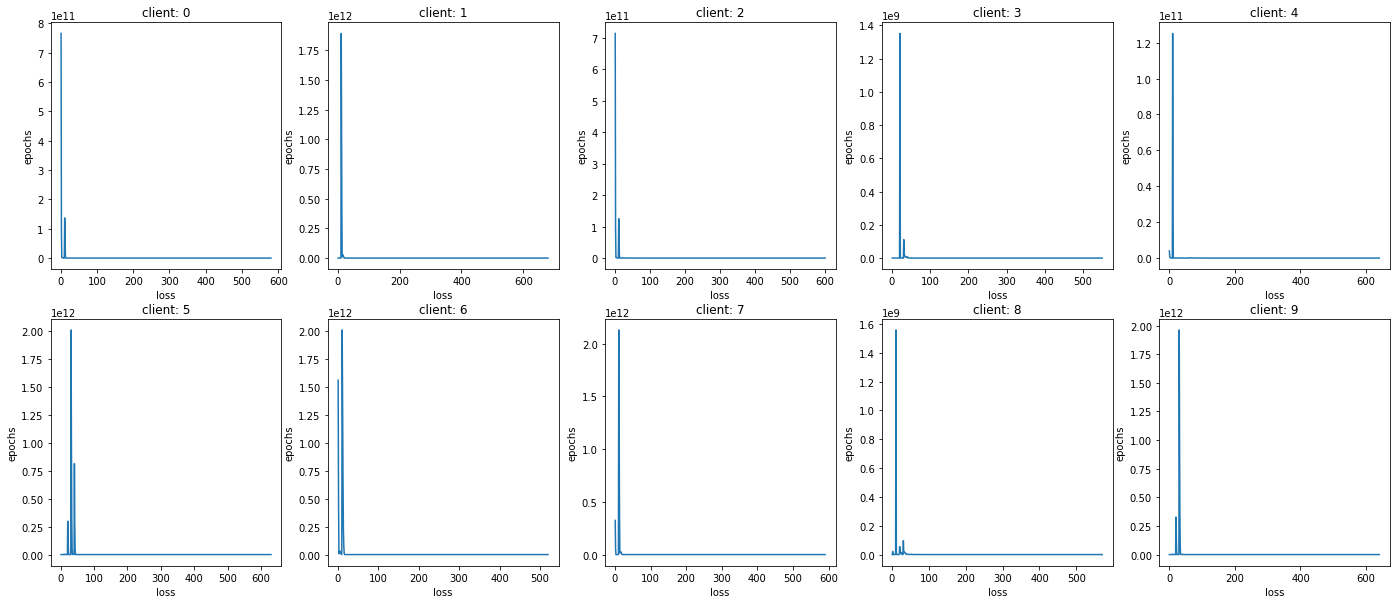

In [7]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    X = global_trainer.client_trainer_set[i].loss_history
    Y = [i+1 for i in range(len(X))]
    plt.plot(Y, X)
    plt.title(f'client: {i}')
    plt.xlabel('loss')
    plt.ylabel('epochs')

In [8]:
global_test = GlobalPreprocess()

client_evaluator_set = [ClientEvaluator(i, global_model, client_test[i]) for i in range(n_clients)]
global_evaluator = GlobalEvaluator(global_model, global_test)

Files already downloaded and verified


In [9]:
avg_client_acc = 0
avg_client_loss = 0
avg_client_conf_mat = torch.zeros([10, 10])  
  
for i in range(n_clients):
    client_evaluator_set[i].test()
    avg_client_acc += client_evaluator_set[i].accuracy
    avg_client_loss += client_evaluator_set[i].loss
    print(type(client_evaluator_set[i].conf_mat), type(avg_client_conf_mat))
    avg_client_conf_mat = torch.add(avg_client_conf_mat, client_evaluator_set[i].conf_mat)
    
avg_client_acc /= n_clients
avg_client_loss /= n_clients
avg_client_conf_mat  = torch.div(avg_client_conf_mat, n_clients)
    

client [0]: 100%|██████████| 63/63 [00:01<00:00, 45.52it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [1]: 100%|██████████| 63/63 [00:01<00:00, 49.00it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [2]: 100%|██████████| 63/63 [00:01<00:00, 62.48it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [3]: 100%|██████████| 63/63 [00:00<00:00, 63.75it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [4]: 100%|██████████| 63/63 [00:01<00:00, 61.15it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [5]: 100%|██████████| 63/63 [00:00<00:00, 66.10it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [6]: 100%|██████████| 63/63 [00:01<00:00, 55.50it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [7]: 100%|██████████| 63/63 [00:00<00:00, 66.66it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [8]: 100%|██████████| 63/63 [00:00<00:00, 65.85it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [9]: 100%|██████████| 63/63 [00:00<00:00, 64.76it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'>


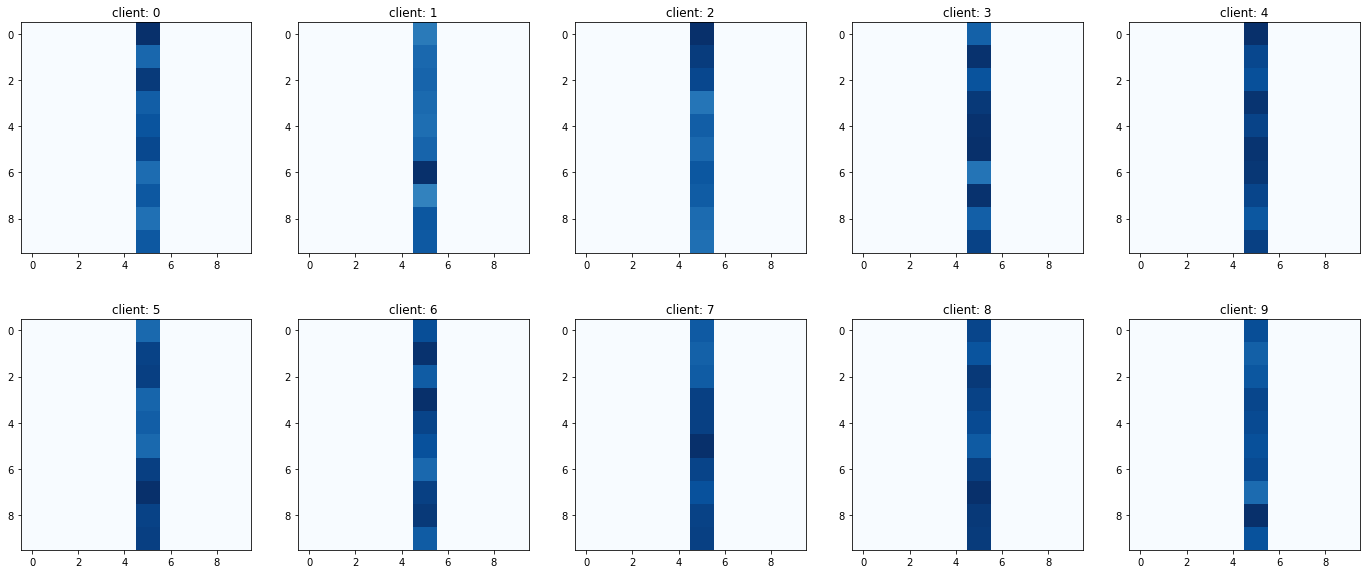

In [10]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    plt.imshow(client_evaluator_set[i].conf_mat, cmap='Blues')
    plt.title(f'client: {i}')


<BarContainer object of 10 artists>

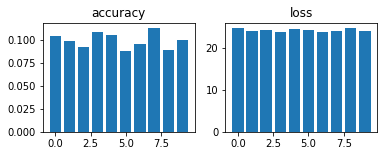

In [11]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.bar([i for i in range(n_clients)], [client_evaluator_set[i].accuracy for i in range(n_clients)])
plt.title('accuracy')
fig.add_subplot(1, 2, 2)
plt.title('loss')   
plt.bar([i for i in range(n_clients)], [client_evaluator_set[i].loss for i in range(n_clients)])


In [12]:
global_evaluator.test()

global_evaluation: 100%|██████████| 157/157 [00:08<00:00, 19.22it/s]


Text(0.5, 1.0, 'clieint average')

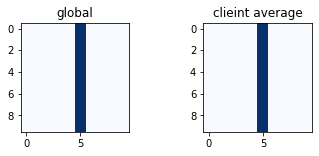

In [13]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.imshow(global_evaluator.conf_mat, cmap='Blues')
plt.title('global')
fig.add_subplot(1, 2, 2)
plt.imshow(avg_client_conf_mat, cmap='Blues')
plt.title('clieint average')


In [14]:
print('Global Accuracy', global_evaluator.accuracy, '\tClient avg Accuracy', avg_client_acc)
print('Global Loss' , global_evaluator.loss, '\tClient avg Loss', avg_client_loss)

Global Accuracy 0.10041799363057324 	Client avg Accuracy 0.09990079365079366
Global Loss 24.193040695117915 	Client avg Loss 24.214777101959605
